***
# Design of a Table File System for an evolving Master Catalogue

***

<div class="alert alert-block alert-info"> This Jupyter Notebook serves as additional guideline for Chapter 6 in my Master Thesis. All code used to analyse data and produce plots is presented here 

</div>

<font color="#31688e">   <i>
    The conceptual, logical and physical design is discussed in Chapter 6 of the thesis. In Section 6.3, 6.4 and 6.5 the implementation, [testing, evaluating](#testeval) and operating phases are discussed. In this Jupyter notebook we go through the steps explained in the thesis. If necessary, we provide the reader with some additional information, links and references to guide it through the steps to set-up our initial AstrometricSolutions Retrieval System
<br>
<i>
The purpose of this chapter is to think about how to set-up a queryable $\texttt{MasterCatalogue}$ consisting of a `MasterTable` that obtains its information as it is being fed by the $\texttt{Core Tables}$: `AssociationTable`, `AstromSolutionsTable` and `SourceExtractionTable`. </i>   </font>
    
<b>We start with an initial set-up by dividing information obtained from three `AssociateList` objects, in this case `AssociateList.ALID == 2708971, 2702831, 2709001`. Every `ALID` is created with a different `.associatelisttype`: (1)Chain, (2)Master and (3)Matched respectively. Every seperate `AssociateList` is stored in three `core tables` with the subscript _1, _2 and _3. This allows us to practice how we want to create our primary keys representing cross-matches from sources in our `SourceList`'s and which associationtype fits best for our System. 

The table is set up using SQLite language, using the standard Python [`sqlite3`](https://docs.python.org/3/library/sqlite3.html) module. This module is intended for working with internal data storages. This module is a SQL interface compliant with the DB-API 2.0 specification. Previously we used `pickle` to store data in .data files in the AstroWISE environment. Thereafter, in a general environment we could open the file and use Python's `pandas` module to create a human readable and queryable table. Since `sqlite3` is included in the Python Standard Library, we solve our problem of having to work in two different environments.    </b> 
    
    
    
<a id = "LOC" LOC></a>


<div class="alert alert-block alert-info">
<b>  List of content of Chapter 6</b> <br>
<i> Figure and Table numbers refer to the numbers in the thesis </i>
    <br> <br>

[6.1](#6.1) <b>Initial Study of System Requirements</b> . . . . . . . . . . . . . . . . . . . . . . . . <br>

[6.1.1] Defining System Requirements . . . . . . . . . . . . . . . . . . . . . . . . . . . . . <br>
[6.1.2] Analysing Boundaries . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .<br>
[6.1.3] Scope of this Research . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .<br>

[6.2](#6.2) <b>The Database Design</b> . . . . . . . . . .  . . . . . . . . . . . . . . . . . . . . . . . . . . . <br>
[6.2.1] Programming Language Selection . . . . . . . . . . . . . . . . . . . . . . . . . . <br>
[6.2.4](#6.2.4) Physical design . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . <br>

[6.3](#6.3) <b>Implementation and loading: Generating Tables</b> . .  . . . . . . . . . . . . <br>
[6.3.1](#6.31) Creation of the MasterCatalogue and its Tables . . . . . . . .  . . . . . . . . <br>
[6.3.2](#6.32) Loading of Data into Tables . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . <br>
[6.3.3](#6.33) Importing external astrometric solutions . . . . . . . . . . . . . . . . . . . . . . <br>
[6.3.4](#6.34) Importing instrument astrometric solutions . . .  . . . . . . . . . . . . . . . . . <br>
[6.3.5](#6.35) Importing USNO-B1.0 calibrated astrometric solutions . . . . . . . . . . . <br>
[6.3.6](#6.36) Initialising the MasterTable . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . <br>

[6.4](#6.4) <b>Testing and Evaluation</b> . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . [Figure 6.7](#figure1)<br>

[6.5](#6.5) <b>Operations: How to use the EMC System?</b> . . . . . . . . . . . . . . . . . . . .[Figure 6.10](#figure2)


</div>





In [3]:
from __future__ import print_function

import warnings
warnings.filterwarnings("ignore")
%run py/setup_awe

try:
    context.set_project('OMEGACAM@VST')
    context.set_privileges(3)
    radec_SA113=[325.375,0.499]
    ra_SA113,dec_SA113,dra_SA113,ddec_SA113=radec_SA113[0],radec_SA113[1],1.,1.
    radec_SA107=[234.825,-0.263] 
    ra_SA107,dec_SA107,dra_SA107,ddec_SA107=radec_SA107[0],radec_SA107[1],1.,1.
except NameError as err:
    print("NameError: Module Context not imported, go to AW environment")
    pass


def check_system():
    try: 
        context.set_project('OMEGACAM@VST')
        context.set_privileges(3)
        return 'awe'
    except NameError as err:
        return 'local'

ImportError: Module Context not imported, go to AW environment
NameError: Module Context not imported, go to AW environment


In [4]:
import sqlite3
import pickle
import datetime
import numpy as np
try: 
    import pandas as pd
    import seaborn as sns
    from scipy.stats import norm, gamma
    import scipy.stats
    from pandas.plotting import register_matplotlib_converters
    register_matplotlib_converters()
except ImportError as err:
    print("ImportError: Python pandas module not imported, not available in Astro-WISE environment")
    import sqlite3
    pass

import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib.cm as cmx
from matplotlib.gridspec import GridSpec
from matplotlib.lines import Line2D
import matplotlib.ticker as ticker
from matplotlib.ticker import FixedLocator, FixedFormatter

import matplotlib.dates as dates

import sys
import os

sys.path.insert(1,"../../pythonscripts/")

from Astrom import AstromAW

import pixel2radec as p2rd
import select_from_awedb as slct
import plotutils_awe as pltut


def _to_hex(c):
    """Convert arbitray color specification to hex string.
    
    Usage: 
        color = _to_hex((0.267004, 0.004874, 0.329415)) 
    Returns:
        HEX colors in the form of #440154
    
    """
    ctype = type(c)

    # Convert rgb to hex.
    if ctype is tuple or ctype is np.ndarray or ctype is list:
        return colors.rgb2hex(c)
    if ctype is str:
        # If color is already hex, simply return it.
        regex = re.compile('^#[A-Fa-f0-9]{6}$')
        if regex.match(c):
            return c
        # Convert named color to hex.
        return colors.cnames[c]
    raise Exception("Can't handle color of type: {}".format(ctype))

# Obtaining colors for scatter plot
purple = _to_hex((0.267004, 0.004874, 0.329415))
blue_purple = _to_hex((0.267968, 0.223549, 0.512008))
blue = _to_hex((0.190631, 0.407061, 0.556089))
green_blue = _to_hex((0.128729, 0.563265, 0.551229))
green_blue2 = _to_hex((0.288921, 0.758394, 0.428426))
green = _to_hex((0.20803, 0.718701, 0.472873))
yellow_green = _to_hex((0.555484, 0.840254, 0.269281))
yellow = _to_hex((0.993248, 0.906157, 0.143936)) 

# print(purple, blue_purple, blue, green_blue, green_blue2, green, yellow_green, yellow)

# Obtaining colors for exclusion zones
silver = _to_hex((0.93, 0.93, 0.93))
grey_blue = _to_hex((0.36, 0.48, 0.58))  
hist_purple = '#7F7FFF'  # the color used for all histograms, taking into acount its alpha
cum_red = '#FD0306' #the color used for all cumulative histogram plots

#print(silver, grey_blue)

In [5]:
db_Chapter6 = "data/MasterCatalogue_Chapter6.db"

def test_query(query, db_file=db_Chapter6, p='no'):
    conn = sqlite3.connect(db_file)
    with conn:
        c = conn.cursor()
        c.execute(query)
    print("Query database for: '''{}'''".format(query))
    if p == 'yes':
        print("OUTPUT SQLITE > {}\n".format(c.fetchall()))
    else:
        print("To print OUTPUT query, set p to 'yes': test_query(query, db_file, p='yes')")
    return None

def run_query(query, output='tuple', db_file=db_Chapter6):
    conn = sqlite3.connect(db_file)
    with conn:
        c = conn.cursor()
        c.execute(query)
    # The method fetches all rows of a query result set and returns a list of tuples.
    if output == 'tuple':
        return c.fetchall()
    elif output == 'array':
        try: 
            records=c.fetchall()
            nr_q = len(records)
            nr_columns = len(records[0])
            data = [[row[i] for row in records] for i in range(nr_columns)] 
            if len(data) == 1:
                return [[row[i] for row in records] for i in range(nr_columns)][0]
            else:
                return [[row[i] for row in records] for i in range(nr_columns)]  
        except IndexError as err:
            return [row[0] for row in records]
    else:
        print("AttibuteError: run_query() only takes output = 'tuple' or 'array' as input")
    return None
    
def _get_attrlist(table_name, db_file=db_Chapter6):
    # attrlist_AID_SA_113 = _get_attrlist("AID_SA_113")
    # attrlist_ALID_SA_113 = _get_attrlist("ALID_SA_113")
    # attrlist_SLID_SA_113 = _get_attrlist("SLID_SA_113")
    query_attrlist = '''select * from pragma_table_info("{}")'''.format(table_name)
    attrlist_table = [q[1] for q in run_query(query_attrlist, db_file=DB)]
    return (attrlist_table)

def _get_slid_ids(table_name, db_file=db_Chapter6):
    # slids_ALID_SA_113_master = _get_slid_ids("ALID_SA_113")[0]
    query_slid_ids = '''select DISTINCT SLID from {}'''.format(table_name)
    aslid_ids_table = [q[0] for q in run_query(query_slid_ids, db_file=DB)]
    return (aslid_ids_table)

def _get_obs_date(table_name, db_file=db_Chapter6):
    # attrlist_te = _get_obs_date("SLID_SA_113")
    query_obs_date = '''select DISTINCT OBS_TIME from {}'''.format(table_name)
    obs_date_table = [q[0] for q in run_query(query_obs_date, db_file=DB)]
    return (obs_date_table)

def _get_unique_aid(slid, AID_table_name="AssociationTable", db_file=db_Chapter6):
    query_SLIDunique = '''SELECT DISTINCT AID_PAIR FROM {} WHERE AID_SLID1 IS {}'''.format(AID_table_name, slid)
    slids_unique = [q[0] for q in run_query(query_SLIDunique, db_file=DB)]
    return (slids_unique)

In [2]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script> <i>
The code used to load the data, plot the Figures & Tables and analyse the results is hidden by default.
To show the raw code, click  <a href="javascript:code_toggle()">here</a> </i>.''') 


<br><br>

[Go back to list of contents](#LOC)

<a id = "6.1" LOC></a>
***
# Design of a Table File System for an evolving Master Catalogue
***




<a id = “requirements” LOC></a>
 
### Defining System Requirements 
 

The following requirements are set to be our goal of our own EMC System:


*   Astrometrical information should be stores per $\texttt{CelestialObject}$. 
*   The system should link $\texttt{SourceExtraction}$s to $\texttt{CelestialObject}$ using an unique identifier for every $\texttt{CelestialObject}$.
*   Position for the $\texttt{CelestialObject}$s are based on the latest information available in the system.
*   The system should know if an entry is a $\texttt{Calibrator}$ or a $\texttt{Non-Calibrator}$.
*   Using the system, users should be able to identify new $\texttt{CelestialObject}$s using clustered $\texttt{Source Extractions}$.
*   The $\texttt{MasterCatalogue}$ can only grow and not shrink. Old information is not changed or removed. 


 
### Analysing Boundaries
 
We set bounderies to define an achievable goal: 


*   able to ingest and update reduced data coming from one instrument
*   make use of data, astrometric calibration and association functionality of AstroWISE
*   able to run in a Jupyter Notebook environment
*   be scalable up until a realistic set of $\texttt{AstrometricSolutions}$
*   focusing on innovation: achieving an update-able master catalogue
*   be provided with users-instructions on how to retrieve/obtain the desired $\texttt{AstrometricSolutions} $


 
### Scope of this Research
 

We will only use the principle behind local astrometry of the OmegaCAM instrument. No global astronomy will be taken into account, meaning we will only focus on the $\texttt{AstrometricSolution}$s that are provided by calibrating 12 $\texttt{DetectorImage}$. This means each $\texttt{DetectorImage}$ is astrometrically calibrated independently.





<br><br>

[Go back to list of contents](#LOC)

<a id = "6.2" LOC></a>
***
# The Database Design 
***



<a id = “6.2.1” LOC></a>
 
### Programming Language Selection

#### Using SQLITE3 as data storage tool

We will start with setting up a basic system where data of an AssociateList is stored into three seperate tables:
1. <b>SourceExtractionTable</b>: containing all information regarding the intrument definition of an $\texttt{SourceExtraction}$ like, $\texttt{X, Y}$ coordinates
* <b>AstromSolutionTable</b>: containing all information regarding the $ \texttt{AstrometricSolution}$s of the $\texttt{SourceExtraction}$
* <b>AssociationTable</b>: containing the pairings as produced by Master Association

Since we want to avoid manu seperate data files, we will start with rewrite the functions `get_AssociationList_data()` and the `get_SourceList_data` directly to functions that allow storage into a SQLite database. After that we can do some exercises, to see whether the combination of SLID and SID works as an usefull `PRIMARY KEY` for matches. 



To facilitate the programming we combine Python programming with SQL queries. What do we mean by this?
* Queries that `CREATE`, `DROP` or `INGEST OR IGNORE` are executed direcly to the database ( in any case ). 
* Queries that `SELECT` do we store in either tuples or arrays to produce an other query. We defined the function `run_query()` to do this.

``` python

def run_query(query, output='tuple', db_file=db_MasterCh6):
    conn = sqlite3.connect(db_file)
    with conn:
        c = conn.cursor()
        c.execute(query)
    # The method fetches all rows of a query result set and returns a list of tuples.
    if output == 'tuple':
        return c.fetchall()
    elif output == 'array':
        try: 
            records=c.fetchall()
            nr_q = len(records)
            nr_columns = len(records[0])
            data = [[row[i] for row in records] for i in range(nr_columns)] 
            if len(data) == 1:
                return [[row[i] for row in records] for i in range(nr_columns)][0]
            else:
                return [[row[i] for row in records] for i in range(nr_columns)]  
        except IndexError as err:
            return [row[0] for row in records]
    else:
        print("AttibuteError: run_query() only takes output = 'tuple' or 'array' as input")
    return None

```

An other function called `check_system()` identifies the environment during some ingestions.

``` python
def check_system():
    try: 
        context.set_project('OMEGACAM@VST')
        context.set_privileges(3)
        return 'awe'
    except NameError as err:
        return 'local'

```



<br> 

[Go back to list of contents](#LOC)

<a id = “6.2.4” LOC></a>
 
### Physical design
 


### Converting my Python functions to SQLlite tables
As mentioned in the method, we would like to set up an table system using SQL language. We started our analysis using Pandas. Pandas, [Python Data Analysis Library](https://pandas.pydata.org/), is a Python library for data science supporting many operations on data sets and providing a streamlined form of data representation. This helps to analyze and understand data better. However, we want to set up an Relational Database Management System, RDBMS. For this purpose it is more convinient to set up a table supporting SQL query language. There are multiple Python SQL libaries. We choose to use the module `sqlite3`. This create a table that is both compatible for the Astro-WISE and any other Python environment. 


To create the tables in SQL we have to set for each column its associated data type that defines the kind of data it can store like integers, floats, strings, ect.  


| INSTRUMENT |    DI_ID   |    D_ID   |    S_ID   | TIME_OBS | TIME_ADD |       X       |       Y      |    FLUX_APER    |   FLUXERR_APER  |     FLUX_ISO    |   FLUXERR_ISO   |    ERRX2_IMAGE   |    ERRY2_IMAGE   | ERRXY_IMAGE      | S_N       | PLATESCALE      |
|:---------:|:---------:|:---------:|:---------:|:---------:|:---------:|:--------------:|:--------------:|:---------------:|:---------------:|:---------------:|:---------------:|:---------------:|:----------------:|:----------------:|:----------------:|:---------------:|
|'TEXT' | 'INTEGER' |'TEXT'| 'INTEGER' | 'DATETIME' | 'DATETIME' | 'DECIMAL(9,6)' | 'DECIMAL(9,6)' | 'DECIMAL(12,6)' | 'DECIMAL(10,6)' | 'DECIMAL(12,6)' | 'DECIMAL(10,6)' | 'DECIMAL(12,10)' | 'DECIMAL(12,10)' | 'DECIMAL(12,10)' | 'DECIMAL(10,6)' | 'DECIMAL(10,6)' |

<center> <i><b>Table 1:</b>  Content of SourceExtractionTable (ALIDTable)    </i> </center> 

| INSTRUMENT |    DI_ID   |    D_ID    | ORIGIN|  TIME_OBS |     CDi_j  |     CRPIX1/1     |     CRVAL1 /2    |      CTYPE1/2     |     AIRMASS     |   ALT_AZ  |   REFCAT  |    NREF   |       RMS       |     MEAN/SIG_DRA     |    MEAN/SIG_DDEC    |
|:---------:|:--------:|:---------:|:--------:|:---------------:|:---------------:|:--------------:|:---------------:|:--------------:|:--------------:|:---------:|:---------:|:---------------:|:---------------:|:---------------:|:---------------:|
| 'TEXT' | 'INTEGER' | 'TEXT' |  'DATE'  | 'TEXT' | 'DECIMAL(10,8)' |  'DECIMAL(7,3)' | 'DECIMAL(9,6)' | 'CHARACTER(10)' | 'DECIMAL(7,3)' | 'DECIMAL(9,6)' | 'CHAR(6)' | 'INTEGER' | 'DECIMAL(10,6)' | 'DECIMAL(10,6)' | 'DECIMAL(10,6)'  |

<center> <i><b>Table 2:</b>  Content of AstromSolutionTable (SLIDTable)    </i> </center> 


|  CO_ID | DI_ID1 | D_ID1 | DI_ID2 | D_ID2 |    DISTANCE   |
|:---------:|:---------------:|:--------------:|:---------------:|:--------------:|:-------------:|
| 'INTEGER' |    'INTEGER'    |    'INTEGER'   |    'INTEGER'    |    'INTEGER'   | 'FLOAT(12,9)' |

<center> <i><b>Table 3:</b>  Content of AssociationTable (AIDTable)   </i> </center> 

| CO_ID | <b>MASTERTABLEUPDATE_ID</b> | MASTER_TYPE | INSTRUMENT | CATEGORY  | REFCAT |       RA       |     RA_ERR     | DEC            | DEC_ERR        | PM             | PM_ERR         | FLUX_ISO    |    FLUXERR_ISO    |    MAG   |  VALID   |   CALIBRATOR   |  FASTMOVING   |   ADDITION    |
|:---------:|:---------:|:---------:|:---------:|:-----------:|------------|:--------------:|:--------------:|:--------------:|:--------------:|:--------------:|:---------:|:---------:|:---------:|:--------------:|:---------:|:---------:|:-----------:|:---------:|
| 'INTEGER' | 'INTEGER' |  'INTEGER'  |  'VARCHAR'  | 'DATETIME' | 'DATETIME' | 'DECIMAL(9,6)' | 'DECIMAL(9,6)' | 'DECIMAL(9,6)' | 'DECIMAL(9,6)' | 'DECIMAL(9,6)' | 'DECIMAL(9,6)' |  'DECIMAL(12,6)' |  'DECIMAL(10,6)'  |  'DECIMAL(9,6)'  |  'TEXT'  |  'TEXT'  |  'TEXT'  |  'TEXT'  |

<center> <i><b>Table 4:</b>  Content of MasterTable    </i> </center> 


There are a few columns speficied specifically for this project:
* 'MASTER_TYPE' 
       * 0: External Astronomical Solutions -- External Reference Catalogue
       * 1: Instrumental Astronomical Solutions -- RAW solutions
       * 2: Calibrated Astronomical Solutions -- Using catalogue to produce AstrometricParameters
       * 3: Internal Astronomical Solutions -- [goal Euclid VIS Reference catalogue] No external reference needed
*  'MASTERTABLEUPDATE_ID'
        * Every new update/upgrade obtains a new MASTERTABLEUPDATE_ID so we keep track of the updates and easily query the table. 

And some extra flags:
* 'VALID'
       * YES or NO
       * Quality tag
* 'CALIBRATOR'
       * YES or NO
       * Marks hwether an record in the `MasterTable` can be used as a calibrator. 
* 'FASTMOVING'
       * YES or NO
       * Not used, will be used for proper motion analysis
* 'ADDITION'
       * YES or NO
       * After new $\texttt{CelestialObject}$ is added to the `MasterTable`




<br><br>

[Go back to list of contents](#LOC)

<a id = "6.3" LOC></a>
***
# Implementation and loading: Generating Tables
***


<br> 

[Go back to list of contents](#LOC)

<a id = “6.31” LOC></a>
 
### Creation of the MasterCatalogue and the $\texttt{Core Tables}$

The first step to set up the $\texttt{MasterCatalogue}$
 is the creation of the database. The creation is quiet straightforward. The user only has to connect to a database file, using `conn = sqlite3 . connect ( database_name.db )` and the `database_name.db` file is stored in the current directory. 
 
``` bash
1 import sqlite3
2
3 database = " MasterCatalogue .db"
4
5 conn = sqlite3 . connect ( database )
6 c = conn . cursor () # connect
7
8 c. execute (" INSERT UNTO ... ") # execute a statement
9 c. execute (" UPDATE ... ")
10
11 conn . commit () # Always commit the queries after a number of executed queries . They are
causing changes into the tables in the database .
12
13 c. execute (" SELECT ... ")
14 c. fetchall ()
15 c. close () # close the cursor object
16
17 conn . close () # close the database
 ``` 
 
The nest step is the creation of the $\texttt{Core Tables}$. The $\texttt{Core Tables}$ will feed the `MasterTable` with information regarding the associations made between with pairs of $\texttt{SourceExtraction}$/ $\texttt{SourceExtraction}$ and $\texttt{SourceExtraction}$/$\texttt{CelestialObject}$.


We chose to combine the generation of the tables with the first ingestion of both instrumental and calibrated astrometric solutions. The data is coming from $\texttt{AssociateList.ALID == 2709001}$


<div class="alert alert-block alert-info">
<b>Note:</b> To run the cells below, the user needs to be in the AstroWISE environment. <br>This is why all code outputs are noted in this notebook using Markdown cells.</div>

In [3]:
# To keep using these notebooks as an working example we choose to make a seperate MasterCatalogue for this chapter
db_Chapter6 = "data/MasterCatalogue_Chapter6.db"

In [26]:
def generate_ALIDtable(alid, name='SourceExtractionTable', db_file=None):
    try:
        AL = (AssociateList.ALID == alid)
    except NameError as err:
        print("NameError: name 'AssociateList' is not defined, go to AW environment to use 'generate_ALIDtable()''")
        return 

    conn = sqlite3.connect(db_file)
    c = conn.cursor()
    print("Connected to database...")

    table_name = name  # name of the table to be created
    column_instrument='INSTRUMENT'; column_detimage = 'DI_ID'; column_det_id = 'D_ID'; column_sid = 'S_ID'; column_timeobs = 'TIME_OBS'; column_timeadd = 'TIME_ADD'; column_x = 'X'; column_y = 'Y' 
    column_fluxaper = 'FLUX_APER'; column_fluxerraper = 'FLUXERR_APER';  column_fluxiso = 'FLUX_ISO'; column_fluxerriso = 'FLUXERR_ISO' #ect 
    column_errx2im = 'ERRX2_IMAGE'; column_erry2im = 'ERRY2_IMAGE'; column_errxyimage = 'ERRXY_IMAGE'; column_s2n = 'S_N'; column_platescale = 'PLATESCALE'#ect

    sqlquery_dropTable = '''DROP TABLE {a_tn}'''.format(a_tn=table_name)
    sqlquery_createTable = '''CREATE TABLE IF NOT EXISTS {a_tn} ({a_instrument} TEXT DEFAULT UNKNOWN, {a_detimage} INTEGER NOT NULL, {a_det_id} TEXT DEFAULT NULL, 
                        {a_sid} INTEGER NOT NULL, {a_timeobs} DATETIME DEFAULT CURRENT_TIMESTAMP, {a_timeadd} DATETIME DEFAULT CURRENT_TIMESTAMP, 
                        {a_x} DECIMAL(9,6), {a_y} DECIMAL(9,6), {a_fluxaper} DECIMAL(12,6), {a_fluxerraper} DECIMAL(10,6), 
                        {a_fluxiso} DECIMAL(12,6), {a_fluxerriso} DECIMAL(10,6), {a_errx2im} DECIMAL(12,10), {a_erry2im} DECIMAL(12,10), 
                        {a_errxyimage} DECIMAL(12,10), {a_s2n} DECIMAL(10,6), {a_platescale} DECIMAL(10,6), PRIMARY KEY ({a_detimage}, {a_det_id}, {a_sid}), FOREIGN KEY({a_detimage}, {a_det_id}) REFERENCES AstromSolutionTable ({a_detimage}, {a_det_id})
                        );'''.format(a_tn=table_name, a_instrument=column_instrument, a_detimage=column_detimage, a_det_id=column_det_id, a_sid=column_sid, 
                                     a_timeobs=column_timeobs, a_timeadd=column_timeadd, a_x=column_x, a_y=column_y, a_fluxaper=column_fluxaper, 
                                     a_fluxerraper=column_fluxerraper, a_fluxiso=column_fluxiso, 
                                     a_fluxerriso=column_fluxerriso, a_errx2im=column_errx2im, a_erry2im=column_erry2im, 
                                     a_errxyimage=column_errxyimage, a_s2n=column_s2n, a_platescale=column_platescale)
    try:
        c.execute(sqlquery_dropTable)
        print('{}, done'.format(sqlquery_dropTable))
    except:
        pass
    print(sqlquery_createTable)
    c.execute(sqlquery_createTable)

    AL = (AssociateList.ALID == alid)
    print("Importing data from AssociateList with ALID {}".format(alid))

    SLs = [sl.SLID for sl in AL[0].sourcelists]
    data_float = [] 
    attrlist = ['SLID', 'SID', 'RA', 'DEC', 'Xpos', 'Ypos', 'FLUX_APER', 'FLUXERR_APER', 'FLUX_ISO', 'FLUXERR_ISO', 'FLUX_AUTO', 'FLUXERR_AUTO', 'ERRX2_IMAGE', 'ERRY2_IMAGE', 'ERRXY_IMAGE']

    al_data_floats = AL[0].associates.get_data(attrlist, mask=None, mode='ANY', count=None, countmode='EQ')
    al_idxs = [key for key in al_data_floats.keys()] # al_idxs are association list indexes from which we obtain attrlist
    al_idxs.sort() # Sort by AssociateList index

    for idx_aid, aid in enumerate(al_idxs):
        print("{}/{}".format(idx_aid, len(al_idxs)), end='\r')
        for source in al_data_floats[aid]:
            v_slid = v_detimage = int(np.array(source[attrlist.index('SLID')]).astype(np.float64))
            v_sid = int(np.array(source[attrlist.index('SID')]).astype(np.float64))
            v_x = float(np.array(source[attrlist.index('Xpos')]).astype(np.float64))
            v_y = float(np.array(source[attrlist.index('Ypos')]).astype(np.float64))

            SL = (SourceList.SLID == v_slid)[0]
            v_fluxaper = v_fluxerraper = v_fluxiso = v_fluxerriso = v_errx2im = v_erry2im = v_errxyimage = v_s2n = 'NULL'
            if v_slid == 565361 or v_slid == 76568851: 
                pass
            else:
                v_fluxaper = float(np.array(source[attrlist.index('FLUX_APER')]).astype(np.float64))
                v_fluxerraper = float(np.array(source[attrlist.index('FLUXERR_APER')]).astype(np.float64))
                v_fluxiso = float(np.array(source[attrlist.index('FLUX_ISO')]).astype(np.float64))
                v_fluxerriso = float(np.array(source[attrlist.index('FLUXERR_ISO')]).astype(np.float64))
                v_errx2im = float(np.array(source[attrlist.index('ERRX2_IMAGE')]).astype(np.float64)) #pixel^2
                v_erry2im = float(np.array(source[attrlist.index('ERRY2_IMAGE')]).astype(np.float64)) #pixel^2
                v_errxyimage = float(np.array(source[attrlist.index('ERRXY_IMAGE')]).astype(np.float64))
                v_s2n = float(v_fluxaper/v_fluxerraper)
                v_det_id = SL.chip.name
                v_instrument = SL.instrument.name
                v_platescale = SL.frame.astrom.get_pixelarea() # platescale pixelarea^2
                v_time_obs = SL.frame.DATE_OBS
                c.execute('''INSERT OR IGNORE INTO {a_tn} ({a_instrument}, {a_detimage}, {a_det_id},  {a_sid}, {a_timeobs}, {a_timeadd}, {a_x}, {a_y}, {a_fluxaper}, {a_fluxerraper}, {a_fluxiso}, {a_fluxerriso}, 
                          {a_errx2im}, {a_erry2im}, {a_errxyimage}, {a_s2n}, {a_platescale}) 
                          VALUES ('{vi}', {vexp}, '{v0}', {v1}, DATETIME('{vtime_obs}'), DATETIME('{vtime_add}'), {v2}, {v3}, 
                          {v8}, {v9}, {v10}, {v11}, {v12}, {v13}, '{v14}', {v15}, {v16})'''. \
                          format(a_tn=table_name, a_instrument=column_instrument, a_detimage=column_detimage, a_det_id=column_det_id, a_sid=column_sid, 
                             a_timeobs=column_timeobs, a_timeadd=column_timeadd, a_x=column_x, a_y=column_y, a_fluxaper=column_fluxaper, 
                             a_fluxerraper=column_fluxerraper, a_fluxiso=column_fluxiso, a_fluxerriso=column_fluxerriso, a_errx2im=column_errx2im, 
                             a_erry2im=column_erry2im, a_errxyimage=column_errxyimage, a_s2n=column_s2n, a_platescale=column_platescale, 
                             vi =v_instrument, vexp=v_detimage, v0=v_det_id, v1=v_sid, vtime_obs= v_time_obs,
                             vtime_add=datetime.datetime.now(), v2=v_x, v3=v_y, 
                             v8=v_fluxaper, v9=v_fluxerraper, v10=v_fluxiso, v11=v_fluxerriso, v12=v_errx2im, v13=v_erry2im, v14=v_errxyimage, 
                             v15=v_s2n, v16=v_platescale))  
                conn.commit()

    print("Commiting done...")
    print("Table stored as {} in {}".format(table_name, db_file))
    return conn.close()




def generate_SLIDtable(alid, name='AstromSolutionTable', db_file = None):
    try:
        AL = (AssociateList.ALID == alid)
    except NameError as err:
        print("NameError: name 'AssociateList' is not defined, go to AW environment to use 'generate_SLIDtable()''")
        return 

    conn = sqlite3.connect(db_file)
    c = conn.cursor()
    print("Connected to database...")

    table_name = name  # name of the table to be created
    column_instrument = 'INSTRUMENT'; column_detimage = 'DI_ID'; column_det_id = 'D_ID'; column_origin = 'ORIGIN'; column_timeobs = 'TIME_OBS'; column_cd11 = 'CD1_1'; column_cd12 = 'CD1_2'; column_cd21 = 'CD2_1'; column_cd22 = 'CD2_2' # name of the first, second, third and fourth (ect.) column to be created
    column_crpix1 = 'CRPIX1'; column_crval1 = 'CRVAL1'; column_ctype1 = 'CTYPE1'; column_crpix2 = 'CRPIX2'; column_crval2 = 'CRVAL2'; column_ctype2 = 'CTYPE2' #ect.
    column_p1_0 = 'PV1_0'; column_p1_1 = 'PV1_1'; column_p1_2 = 'PV1_2'; column_p1_3 = 'PV1_3'; column_p1_4 = 'PV1_4'; 
    column_p1_5 = 'PV1_5'; column_p1_6 = 'PV1_6'; column_p1_7 = 'PV1_7'; column_p1_8 = 'PV1_8'; column_p1_9 = 'PV1_9'; 
    column_p1_10 = 'PV1_10'
    column_p2_0 = 'PV2_0'; column_p2_1 = 'PV2_1'; column_p2_2 = 'PV2_2'; column_p2_3 = 'PV2_3'; column_p2_4 = 'PV2_4'; 
    column_p2_5 = 'PV2_5'; column_p2_6 = 'PV2_6'; column_p2_7 = 'PV2_7'; column_p2_8 = 'PV2_8'; column_p2_9 = 'PV2_9'; 
    column_p2_10 = 'PV2_10'
    column_airmass = 'AIRMASS'; column_az = "ALT_AZ"; column_refcat = 'REFCAT'; column_nref = 'NREF'; column_rms = 'RMS' #ect.
    column_mdra = 'MEAN_DRA'; column_sdra = 'SIG_DRA'; column_mddec = 'MEAN_DDEC'; column_sddec = 'SIG_DDEC' #ect.

    sqlquery_dropTable = '''DROP TABLE {a_tn}'''.format(a_tn=table_name)
    sqlquery_createTable = '''CREATE TABLE IF NOT EXISTS {a_tn} ({a_instrument} TEXT DEFAULT UNKNOWN, {a_detimage} INTEGER NOT NULL, {a_det_id} TEXT DEFAULT NULL, {a_origin} VARCHAR DEFAULT UNKNOWN, 
                        {a_timeobs} DATETIME, {a_cd11} DECIMAL(10,8), {a_cd12} DECIMAL(10,8), 
                        {a_cd21} DECIMAL(10,8), {a_cd22} DECIMAL(10,8), {a_crpix1} DECIMAL(7,3), {a_crval1} DECIMAL(9,6), {a_ctype1} CHARACTER(10), 
                        {a_crpix2} DECIMAL(7,3), {a_crval2} DECIMAL(9,6), {a_ctype2} CHARACTER(10), 
                        {ap1_0} REAL DEFAULT 0.0, {ap1_1} REAL DEFAULT 0.0,  {ap1_2} REAL DEFAULT 0.0,  {ap1_3} REAL DEFAULT 0.0,  {ap1_4} REAL DEFAULT 0.0,  
                        {ap1_5} REAL DEFAULT 0.0, {ap1_6} REAL DEFAULT 0.0,  {ap1_7} REAL DEFAULT 0.0,  {ap1_8} REAL DEFAULT 0.0,  {ap1_9} REAL DEFAULT 0.0, {ap1_10} REAL DEFAULT 0.0, 
                        {ap2_0} REAL DEFAULT 0.0, {ap2_1} REAL DEFAULT 0.0,  {ap2_2} REAL DEFAULT 0.0,  {ap2_3} REAL DEFAULT 0.0,  {ap2_4} REAL DEFAULT 0.0,  
                        {ap2_5} REAL DEFAULT 0.0, {ap2_6} REAL DEFAULT 0.0,  {ap2_7} REAL DEFAULT 0.0,  {ap2_8} REAL DEFAULT 0.0,  {ap2_9} REAL DEFAULT 0.0, {ap2_10} REAL DEFAULT 0.0, 
                        {a_airmass} DECIMAL(10,6), {a_az} CHAR(6), {a_refcat} TEXT, {a_nref} INTEGER, 
                        {a_rms} DECIMAL(10,6), {a_mdra} DECIMAL(10,6), {a_sdra} DECIMAL(10,6), {a_mddec} DECIMAL(10,6), SIG_DDEC DECIMAL(10,6),
                        PRIMARY KEY ({a_detimage}, {a_det_id}, {a_refcat}) , FOREIGN KEY({a_detimage}, {a_det_id}) REFERENCES SourceExtractionTable ({a_detimage}, {a_det_id}) );'''. \
                        format(a_tn=table_name, a_instrument=column_instrument, a_detimage=column_detimage, a_det_id=column_det_id, a_origin=column_origin, a_timeobs= column_timeobs, a_cd11=column_cd11 , a_cd12= column_cd12, a_cd21= column_cd21, 
                            a_cd22= column_cd22, a_crpix1= column_crpix1, a_crval1= column_crval1, a_ctype1= column_ctype1, a_crpix2= column_crpix2, 
                            a_crval2= column_crval2, a_ctype2= column_ctype2, 
                            ap1_0=column_p1_0, ap1_1=column_p1_1, ap1_2=column_p1_2, ap1_3=column_p1_3, ap1_4=column_p1_4, 
                            ap1_5=column_p1_5, ap1_6=column_p1_6, ap1_7=column_p1_7, ap1_8=column_p1_8, ap1_9=column_p1_9, 
                            ap1_10=column_p1_10,
                            ap2_0=column_p2_0, ap2_1=column_p2_1, ap2_2=column_p2_2, ap2_3=column_p2_3, ap2_4=column_p2_4, 
                            ap2_5=column_p2_5, ap2_6=column_p2_6, ap2_7=column_p2_7, ap2_8=column_p2_8, ap2_9=column_p2_9, 
                            ap2_10=column_p2_10,
                            a_airmass= column_airmass, a_az= column_az, a_refcat= column_refcat, 
                            a_nref= column_nref, a_rms= column_rms, a_mdra= column_mdra, a_sdra= column_sdra, a_mddec= column_mddec, a_sddec= column_sddec)
    try:
        c.execute(sqlquery_dropTable)
    except:
        pass
    c.execute(sqlquery_createTable)

    AL = (AssociateList.ALID == alid)
    print("Importing data from AssociateList with ALID {}".format(alid))
    for ids_SL, SL in enumerate(AL[0].sourcelists):
        print("{}/{}".format(ids_SL, len(AL[0].sourcelists)), end='\r')
        v_slid = SL.SLID
        if v_slid == 565361 or v_slid == 76568851:
            continue
        else:
            pass
        RS = SL.frame
        AP = SL.astrom_params

        v_det_id = (SourceList.SLID == v_slid)[0].chip.name
        v_instrument = SL.instrument.name
        v_slid = v_detimage = SL.SLID; v_timeobs = RS.DATE_OBS; v_cd11 = AP.CD1_1; v_cd12 = AP.CD1_2; v_cd21 = AP.CD2_1; v_cd22 = AP.CD2_2
        v_crpix1 = AP.CRPIX1; v_crval1 = AP.CRVAL1; v_ctype1 = str(AP.CTYPE1); v_crpix2 = AP.CRPIX2; v_crval2 = AP.CRVAL2; v_ctype2 = AP.CTYPE2
        v_p1_0=AP.PV1_0; v_p1_1=AP.PV1_1; v_p1_2=AP.PV1_2; v_p1_3=AP.PV1_3; v_p1_4=AP.PV1_4; 
        v_p1_5=AP.PV1_5; v_p1_6=AP.PV1_6; v_p1_7=AP.PV1_7; v_p1_8=AP.PV1_8; v_p1_9=AP.PV1_9; 
        v_p1_10=AP.PV1_10;
        v_p2_0=AP.PV2_0; v_p2_1=AP.PV2_1; v_p2_2=AP.PV2_2; v_p2_3=AP.PV2_3; v_p2_4=AP.PV2_4; 
        v_p2_5=AP.PV2_5; v_p2_6=AP.PV2_6; v_p2_7=AP.PV2_7; v_p2_8=AP.PV2_8; v_p2_9=AP.PV2_9; 
        v_p2_10=AP.PV2_10;
        v_airmass = np.mean([RS.AIRMEND,RS.AIRMSTRT]); v_az = "ALT_AZ"; v_refcat = AP.process_params.REFCAT; v_origin = 'OmegaCAM SA_113'
        v_nref = AP.NREF; v_rms = AP.RMS
        v_mdra = AP.MEAN_DRA; v_sdra = AP.SIG_DRA; v_mddec = AP.MEAN_DDEC; v_sddec = AP.SIG_DDEC

        c.execute('''INSERT INTO {a_tn} ({a_instrument}, {a_detimage}, {a_det_id}, {a_origin}, {a_timeobs}, {a_cd11}, {a_cd12}, {a_cd21}, {a_cd22}, {a_crpix1}, {a_crval1}, {a_ctype1}, 
                            {a_crpix2}, {a_crval2}, {a_ctype2}, 
                            {ap1_0}, {ap1_1},  {ap1_2},  {ap1_3},  {ap1_4}, {ap1_5}, {ap1_6},  {ap1_7},  {ap1_8},  {ap1_9}, {ap1_10},
                            {ap2_0}, {ap2_1},  {ap2_2},  {ap2_3},  {ap2_4}, {ap2_5}, {ap2_6},  {ap2_7},  {ap2_8},  {ap2_9}, {ap2_10}, 
                            {a_airmass}, {a_az}, {a_refcat}, {a_nref}, {a_rms}, {a_mdra}, {a_sdra}, {a_mddec}, 
                            {a_sddec}) VALUES ('{vi}', {vexp}, '{v0}', '{vo}', DATETIME('{v1}'), {v2}, {v3}, {v4}, {v5}, {v6}, {v7}, '{v8}', {v9}, {v10}, '{v11}',
                            {v_1_0}, {v_1_1},  {v_1_2},  {v_1_3},  {v_1_4}, {v_1_5}, {v_1_6},  {v_1_7},  {v_1_8},  {v_1_9}, {v_1_10},
                            {v_2_0}, {v_2_1},  {v_2_2},  {v_2_3},  {v_2_4}, {v_2_5}, {v_2_6},  {v_2_7},  {v_2_8},  {v_2_9}, {v_2_10}, {v12}, 'ALT-AZ', '{v14}', {v15},
                            {v16}, {v17}, {v18}, {v19}, {v20})'''. \
                  format(a_tn=table_name, a_instrument=column_instrument, a_detimage=column_detimage, a_det_id=column_det_id, a_origin=column_origin, a_timeobs= column_timeobs, a_cd11=column_cd11 , a_cd12= column_cd12, a_cd21= column_cd21, 
                         a_cd22= column_cd22, a_crpix1= column_crpix1, a_crval1= column_crval1, a_ctype1= column_ctype1, a_crpix2= column_crpix2, 
                         a_crval2= column_crval2, a_ctype2= column_ctype2, 
                         ap1_0=column_p1_0, ap1_1=column_p1_1, ap1_2=column_p1_2, ap1_3=column_p1_3, ap1_4=column_p1_4, 
                         ap1_5=column_p1_5, ap1_6=column_p1_6, ap1_7=column_p1_7, ap1_8=column_p1_8, ap1_9=column_p1_9, 
                         ap1_10=column_p1_10,
                         ap2_0=column_p2_0, ap2_1=column_p2_1, ap2_2=column_p2_2, ap2_3=column_p2_3, ap2_4=column_p2_4, 
                         ap2_5=column_p2_5, ap2_6=column_p2_6, ap2_7=column_p2_7, ap2_8=column_p2_8, ap2_9=column_p2_9, 
                         ap2_10=column_p2_10,
                         a_airmass= column_airmass, a_az= column_az, a_refcat= column_refcat, 
                         a_nref= column_nref, a_rms= column_rms, a_mdra= column_mdra, a_sdra= column_sdra, a_mddec= column_mddec, a_sddec= column_sddec, 
                         vi =v_instrument, vexp=v_detimage, v0=v_det_id, vo=v_origin, v1=v_timeobs, v2=v_cd11, v3=v_cd12, v4=v_cd21, v5=v_cd22, v6=v_crpix1, v7=v_crval1, v8=v_ctype1, v9=v_crpix2, 
                         v10=v_crval2, v11=v_ctype2, 
                         v_1_0=v_p1_0, v_1_1=v_p1_1, v_1_2=v_p1_2, v_1_3=v_p1_3, v_1_4=v_p1_4, 
                         v_1_5=v_p1_5, v_1_6=v_p1_6, v_1_7=v_p1_7, v_1_8=v_p1_8, v_1_9=v_p1_9, 
                         v_1_10=v_p1_10,
                         v_2_0=v_p2_0, v_2_1=v_p2_1, v_2_2=v_p2_2, v_2_3=v_p2_3, v_2_4=v_p2_4, 
                         v_2_5=v_p2_5, v_2_6=v_p2_6, v_2_7=v_p2_7, v_2_8=v_p2_8, v_2_9=v_p2_9, 
                         v_2_10=v_p2_10,
                         v12=v_airmass, v14=v_refcat, v15=v_nref, v16=v_rms, v17=v_mdra, v18=v_sdra, v19=v_mddec, 
                         v20=v_sddec))
        conn.commit()

        astromsol = RS.astrom
        v_timeobs = RS.DATE_OBS
        v_cd11 = astromsol.CD1_1; v_cd12 = astromsol.CD1_2; v_cd21 = astromsol.CD2_1; v_cd22 = astromsol.CD2_2
        v_crpix1 = astromsol.CRPIX1; v_crval1 = astromsol.CRVAL1; v_ctype1 = str(astromsol.CTYPE1); 
        v_crpix2 = astromsol.CRPIX2; v_crval2 = astromsol.CRVAL2; v_ctype2 = astromsol.CTYPE2
        v_origin = "OmegaCAM SA_113"
        v_refcat = "INSTRUMENT"

        v_nref = v_rms = v_mdra = v_sdra = v_mddec = v_sddec = 'NULL'

        v_az = "ALT_AZ"
        print('''INSERT INTO {a_tn} ({a_instrument}, {a_detimage}, {a_det_id}, {a_origin}, {a_timeobs}, {a_cd11}, {a_cd12}, {a_cd21}, {a_cd22}, {a_crpix1}, {a_crval1}, {a_ctype1}, 
                            {a_crpix2}, {a_crval2}, {a_ctype2}, {a_airmass}, {a_az}, {a_refcat}, {a_nref}, {a_rms}, {a_mdra}, {a_sdra}, {a_mddec}, 
                            {a_sddec}) VALUES ('{vi}', {v0}, '{vd}', '{vo}', DATETIME('{v1}'), {v2}, {v3}, {v4}, {v5}, {v6}, {v7}, '{v8}', {v9}, {v10}, '{v11}', {v12}, 'ALT-AZ', '{v14}', {v15},
                            {v16}, {v17}, {v18}, {v19}, {v20})'''. \
                  format(a_tn=table_name, a_instrument=column_instrument, a_detimage=column_detimage, a_det_id=column_det_id, a_origin=column_origin, a_timeobs= column_timeobs, a_cd11=column_cd11 , a_cd12= column_cd12, a_cd21= column_cd21, 
                         a_cd22= column_cd22, a_crpix1= column_crpix1, a_crval1= column_crval1, a_ctype1= column_ctype1, a_crpix2= column_crpix2, 
                         a_crval2= column_crval2, a_ctype2= column_ctype2, a_airmass= column_airmass, a_az= column_az, a_refcat= column_refcat, 
                         a_nref= column_nref, a_rms= column_rms, a_mdra= column_mdra, a_sdra= column_sdra, a_mddec= column_mddec, a_sddec= column_sddec, 
                         vi=v_instrument ,v0=v_detimage, vd=v_det_id, vo=v_origin, v1=v_timeobs, v2=v_cd11, v3=v_cd12, v4=v_cd21, v5=v_cd22, v6=v_crpix1, v7=v_crval1, v8=v_ctype1, v9=v_crpix2, 
                         v10=v_crval2, v11=v_ctype2, v12=v_airmass, v14=v_refcat, v15=v_nref, v16=v_rms, v17=v_mdra, v18=v_sdra, v19=v_mddec, 
                         v20=v_sddec))  

        c.execute('''INSERT INTO {a_tn} ({a_instrument}, {a_detimage}, {a_det_id}, {a_origin}, {a_timeobs}, {a_cd11}, {a_cd12}, {a_cd21}, {a_cd22}, {a_crpix1}, {a_crval1}, {a_ctype1}, 
                            {a_crpix2}, {a_crval2}, {a_ctype2}, {a_airmass}, {a_az}, {a_refcat}, {a_nref}, {a_rms}, {a_mdra}, {a_sdra}, {a_mddec}, 
                            {a_sddec}) VALUES ('{vi}', {v0}, '{vd}', '{vo}', DATETIME('{v1}'), {v2}, {v3}, {v4}, {v5}, {v6}, {v7}, '{v8}', {v9}, {v10}, '{v11}', {v12}, 'ALT-AZ', '{v14}', {v15},
                            {v16}, {v17}, {v18}, {v19}, {v20})'''. \
                  format(a_tn=table_name, a_instrument=column_instrument, a_detimage=column_detimage, a_det_id=column_det_id, a_origin=column_origin, a_timeobs= column_timeobs, a_cd11=column_cd11 , a_cd12= column_cd12, a_cd21= column_cd21, 
                         a_cd22= column_cd22, a_crpix1= column_crpix1, a_crval1= column_crval1, a_ctype1= column_ctype1, a_crpix2= column_crpix2, 
                         a_crval2= column_crval2, a_ctype2= column_ctype2, a_airmass= column_airmass, a_az= column_az, a_refcat= column_refcat, 
                         a_nref= column_nref, a_rms= column_rms, a_mdra= column_mdra, a_sdra= column_sdra, a_mddec= column_mddec, a_sddec= column_sddec, 
                         vi=v_instrument ,v0=v_detimage, vd=v_det_id, vo=v_origin, v1=v_timeobs, v2=v_cd11, v3=v_cd12, v4=v_cd21, v5=v_cd22, v6=v_crpix1, v7=v_crval1, v8=v_ctype1, v9=v_crpix2, 
                         v10=v_crval2, v11=v_ctype2, v12=v_airmass, v14=v_refcat, v15=v_nref, v16=v_rms, v17=v_mdra, v18=v_sdra, v19=v_mddec, 
                         v20=v_sddec))  
        conn.commit()

    print("Commiting done...")
    print("Table stored as {} in {}".format(table_name, db_file))
    return conn.close()



def generate_AIDtable(alid, name='AssociationTable', db_file=None):
    try:
        AL = (AssociateList.ALID == alid)
    except NameError as err:
        print("NameError: name 'AssociateList' is not defined, go to AW environment to use 'generate_AIDtable()''")
        return 

    conn = sqlite3.connect(db_file)
    c = conn.cursor()
    print("Connected to database...")

    table_name = name  # name of the table to be created
    column_aid_pair = 'CO_ID'; column_aid_slid1 = 'DI_ID1'; column_aid_sid1 = 'S_ID1'; column_aid_slid2 = 'DI_ID2'
    column_aid_sid2 = 'S_ID2'; column_distance = 'DISTANCE'; column_masterid = 'CO_ID'; column_slid = 'DI_ID'; column_sid = 'S_ID'

    sqlquery_dropTable = '''DROP TABLE {a_tn}'''.format(a_tn=table_name)
    sqlquery_createTable = '''CREATE TABLE IF NOT EXISTS {a_tn} ({a_aid} INTEGER, {a_aslid1} INTEGER, {a_asid1} INTEGER, {a_aslid2} INTEGER, 
                        {a_asid2} INTEGER, {a_distance} FLOAT(12,9),
                        PRIMARY KEY ({a_aid}, {a_distance}) , FOREIGN KEY({a_aid}) REFERENCES MasterTable ({a_masterid}), 
                        FOREIGN KEY({a_aslid1}, {a_asid1}) REFERENCES SourceExtractionTable ({a_slid}, {a_sid}), 
                        FOREIGN KEY({a_aslid2}, {a_asid2}) REFERENCES SourceExtractionTable ({a_slid}, {a_sid})
                        );'''.format(a_tn=table_name, a_aid=column_aid_pair, a_aslid1= column_aid_slid1, a_asid1=column_aid_sid1, a_aslid2= column_aid_slid2, 
                                     a_asid2=column_aid_sid2, a_distance= column_distance, a_masterid=column_masterid, a_slid=column_slid, a_sid=column_sid)
    try:
        c.execute(sqlquery_dropTable)
        print('{}, done'.format(sqlquery_dropTable))
    except:
        pass
    c.execute(sqlquery_createTable)

    print("Importing data from AssociateList with ALID {}".format(alid))
    data_distances = AL[0].get_distances_on_associates()
    nr_pairs = len(data_distances)
    r = AL[0].get_distances_on_associates()
    aids = [k for k in r.keys()]
    for aid in aids:
        v_aid = aid
        print("{}/{}".format(v_aid, len(aids)), end='\r')
        for row in r[aid]:
            v_aslid1, v_asid1, v_aslid2, v_asid2, v_distance = row[0][0], row[0][1], row[1][0], row[1][1], row[2]
            c.execute('''INSERT OR IGNORE INTO {a_tn} ({a_aid}, {a_aslid1}, {a_asid1}, {a_aslid2}, {a_asid2}, {a_distance}) VALUES ({v0}, {v1}, {v2}, {v3}, {v4}, {v5})'''. \
                      format(a_tn=table_name, a_aid=column_aid_pair, a_aslid1=column_aid_slid1, a_asid1=column_aid_sid1, 
                             a_aslid2=column_aid_slid2, a_asid2=column_aid_sid2, a_distance=column_distance, v0=v_aid, 
                             v1=v_aslid1, v2=v_asid1, v3=v_aslid2, v4=v_asid2, v5=v_distance))
            conn.commit()
    print("Commiting done...")
    print("Table stored as {} in {}".format(table_name, db_file))
    return conn.close()



In [7]:
db_Chapter6 = "data/MasterCatalogue_Chapter6.db"

generate_ALIDtable(alid= 2709001, name= 'SourceExtractionTable', db_file=db_Chapter6)
generate_SLIDtable(alid= 2709001, name= 'AstromSolutionTable', db_file=db_Chapter6)
generate_AIDtable(alid= 2709001, name= 'AssociationTable', db_file=db_Chapter6)


Connected to database...
CREATE TABLE IF NOT EXISTS SourceExtractionTable (INSTRUMENT TEXT DEFAULT UNKNOWN, DI_ID INTEGER NOT NULL, D_ID TEXT DEFAULT NULL, 
                        S_ID INTEGER NOT NULL, TIME_OBS DATETIME DEFAULT CURRENT_TIMESTAMP, TIME_ADD DATETIME DEFAULT CURRENT_TIMESTAMP, 
                        X DECIMAL(9,6), Y DECIMAL(9,6), FLUX_APER DECIMAL(12,6), FLUXERR_APER DECIMAL(10,6), 
                        FLUX_ISO DECIMAL(12,6), FLUXERR_ISO DECIMAL(10,6), ERRX2_IMAGE DECIMAL(12,10), ERRY2_IMAGE DECIMAL(12,10), 
                        ERRXY_IMAGE DECIMAL(12,10), S_N DECIMAL(10,6), PLATESCALE DECIMAL(10,6), PRIMARY KEY (DI_ID, D_ID, S_ID), FOREIGN KEY(DI_ID, D_ID) REFERENCES AstromSolutionTable (DI_ID, D_ID)
                        );
Importing data from AssociateList with ALID 2709001
Commiting done...
Table stored as SourceExtractionTable in data/MasterCatalogue_Chapter6.db
Connected to database...
Importing data from AssociateList with ALID 2709001
Commiting done.

We will check whether the table column names and the types are correct.

In [11]:
db_Chapter6 = "data/MasterCatalogue_Chapter6.db"

def get_posts(name, db_file):
    conn = sqlite3.connect(db_file)
    with conn:
        c = conn.cursor()
        c.execute("SELECT * FROM {}".format(name))
        print(c.fetchall())
        
query_get_table_info = '''PRAGMA table_info('{}');'''.format('SourceExtractionTable')
print(query_get_table_info)
run_query(query_get_table_info, db_file=db_Chapter6)

PRAGMA table_info('SourceExtractionTable');


[(0, 'INSTRUMENT', 'TEXT', 0, 'UNKNOWN', 0),
 (1, 'DI_ID', 'INTEGER', 1, None, 1),
 (2, 'D_ID', 'TEXT', 0, 'NULL', 2),
 (3, 'S_ID', 'INTEGER', 1, None, 3),
 (4, 'TIME_OBS', 'DATETIME', 0, 'CURRENT_TIMESTAMP', 0),
 (5, 'TIME_ADD', 'DATETIME', 0, 'CURRENT_TIMESTAMP', 0),
 (6, 'X', 'DECIMAL(9,6)', 0, None, 0),
 (7, 'Y', 'DECIMAL(9,6)', 0, None, 0),
 (8, 'FLUX_APER', 'DECIMAL(12,6)', 0, None, 0),
 (9, 'FLUXERR_APER', 'DECIMAL(10,6)', 0, None, 0),
 (10, 'FLUX_ISO', 'DECIMAL(12,6)', 0, None, 0),
 (11, 'FLUXERR_ISO', 'DECIMAL(10,6)', 0, None, 0),
 (12, 'ERRX2_IMAGE', 'DECIMAL(12,10)', 0, None, 0),
 (13, 'ERRY2_IMAGE', 'DECIMAL(12,10)', 0, None, 0),
 (14, 'ERRXY_IMAGE', 'DECIMAL(12,10)', 0, None, 0),
 (15, 'S_N', 'DECIMAL(10,6)', 0, None, 0),
 (16, 'PLATESCALE', 'DECIMAL(10,6)', 0, None, 0)]

In [16]:
query_get_table_info = '''PRAGMA table_info('{}');'''.format('AstromSolutionTable')
print(query_get_table_info)
run_query(query_get_table_info, db_file=db_Chapter6)

PRAGMA table_info('AstromSolutionTable');


[(0, 'INSTRUMENT', 'TEXT', 0, 'UNKNOWN', 0),
 (1, 'DI_ID', 'INTEGER', 1, None, 1),
 (2, 'D_ID', 'TEXT', 0, 'NULL', 2),
 (3, 'ORIGIN', 'VARCHAR', 0, 'UNKNOWN', 0),
 (4, 'TIME_OBS', 'DATETIME', 0, None, 0),
 (5, 'CD1_1', 'DECIMAL(10,8)', 0, None, 0),
 (6, 'CD1_2', 'DECIMAL(10,8)', 0, None, 0),
 (7, 'CD2_1', 'DECIMAL(10,8)', 0, None, 0),
 (8, 'CD2_2', 'DECIMAL(10,8)', 0, None, 0),
 (9, 'CRPIX1', 'DECIMAL(7,3)', 0, None, 0),
 (10, 'CRVAL1', 'DECIMAL(9,6)', 0, None, 0),
 (11, 'CTYPE1', 'CHARACTER(10)', 0, None, 0),
 (12, 'CRPIX2', 'DECIMAL(7,3)', 0, None, 0),
 (13, 'CRVAL2', 'DECIMAL(9,6)', 0, None, 0),
 (14, 'CTYPE2', 'CHARACTER(10)', 0, None, 0),
 (15, 'PV1_0', 'REAL', 0, '0.0', 0),
 (16, 'PV1_1', 'REAL', 0, '0.0', 0),
 (17, 'PV1_2', 'REAL', 0, '0.0', 0),
 (18, 'PV1_3', 'REAL', 0, '0.0', 0),
 (19, 'PV1_4', 'REAL', 0, '0.0', 0),
 (20, 'PV1_5', 'REAL', 0, '0.0', 0),
 (21, 'PV1_6', 'REAL', 0, '0.0', 0),
 (22, 'PV1_7', 'REAL', 0, '0.0', 0),
 (23, 'PV1_8', 'REAL', 0, '0.0', 0),
 (24, 'PV1_9', 

In [6]:
query_get_table_info = '''PRAGMA table_info('{}');'''.format('AssociationTable')
print(query_get_table_info)
run_query(query_get_table_info, db_file=db_Chapter6)

PRAGMA table_info('AssociationTable');


[(0, 'CO_ID', 'INTEGER', 0, None, 1),
 (1, 'DI_ID1', 'INTEGER', 0, None, 0),
 (2, 'S_ID1', 'INTEGER', 0, None, 0),
 (3, 'DI_ID2', 'INTEGER', 0, None, 0),
 (4, 'S_ID2', 'INTEGER', 0, None, 0),
 (5, 'DISTANCE', 'FLOAT(12,9)', 0, None, 2)]


<br> 

[Go back to list of contents](#LOC)

<a id = “6.36” LOC></a>
 
### Initialising the MasterTable
 
We will start the feeding of the `MasterTable`. 

This has to be done into the following steps:

1.  `MT = MasterTable(db_Chapter6)`   <---  Can be done in either AWE of Anaconda environment<br>
    `MT.generate()`
*   `MT = MasterTable(db_Chapter6)`   <---  Must be done in AWE environment because the Core Tables only miss external information. The reference catalogues that give us the positions of  $\texttt{CelestialObject}$s is the only data that is skipping the `Core Tables`<br>
    `MT.ingest_RefCat(RefCat='USNO-B1.0')`
*   `MT = MasterTable(db_Chapter6)`   <---  Must be done in Anaconda environment<br>
    `MT.ingest_Initial()`

In [11]:
def import_AstromSol_Calibrated(AW_aid, refcat, MasterTable_id, db_file, name='MasterTable', name_add=''):
    table_name = name
    
    # Search for (SLID1, SID1) with Master_ID = i, and (SLID2, SID2) with Master_ID = AID
    slidsid1 = "SELECT DI_ID1, S_ID1 FROM AssociationTable{} WHERE CO_ID = {}".format(name_add ,AW_aid)
    slidsid2 = "SELECT DI_ID2, S_ID2 FROM AssociationTable{} WHERE CO_ID = {}".format(name_add ,AW_aid)
    ss1 = run_query(slidsid1, output='tuple', db_file=db_file)
    ss2 = run_query(slidsid2, output='tuple', db_file=db_file)
    # Obtain unique combination of (SLID, SID) with Master_ID = AID
    uniq = (list(set(ss1+ss2)))
    # Remove REFCATS from list
    uniq_without_REFCAT = [i for i in uniq if i[0] != 565361 and i[0] != 76568851]
    # but keep the information stored to ingest directly into the MasterCatalogue
    slid_sid_refcat = set(uniq)-set(uniq_without_REFCAT)
        
    attributes_observation = ['INSTRUMENT', 'D_ID']
    attribute_obs_time = ['TIME_OBS']
    
    attributes_SE = ['FLUX_ISO', 'FLUXERR_ISO', 'ERRX2_IMAGE', 'ERRY2_IMAGE', 'ERRXY_IMAGE', 'PLATESCALE']
    attr_string_SE = ', '.join('AVG(' + attr +')' for attr in attributes_SE)
        
    attributes_AS = ['CD1_1', 'CD1_2', 'CD2_1', 'CD2_2', 'CRPIX1', 'CRVAL1', 'CRPIX2', 'CRVAL2'] #instrumental values
    attributes_AS_cal = ['PV1_0', 'PV1_1', 'PV1_2', 'PV1_3', 'PV1_4', 'PV1_5', 'PV1_6', 'PV1_7', 'PV1_8', 'PV1_9', 'PV1_10', 'PV2_0', 'PV2_1', 'PV2_2', 'PV2_3', 'PV2_4', 'PV2_5', 'PV2_6', 'PV2_7', 'PV2_8', 'PV2_9', 'PV2_10']    
    
    if refcat != 'INSTRUMENT':
        m_type = 2 ; is_calibrator, is_valid = 'NO','YES' # If multiple sources found, likely to be calibrated source: we set Master_type to 2 and is_calibrator to 0 [False] and is_valid 1 [True]
        attributes_AS.extend(attributes_AS_cal)
        
        select_avg = "SELECT {} FROM SourceExtractionTable{} WHERE (DI_ID,S_ID) IN (VALUES{})".format(attr_string_SE, name_add, str([slid_sid for slid_sid in uniq_without_REFCAT]).strip("[]"))
        attribute_val_SE = run_query(select_avg, output='array', db_file=db_file) # ['FLUX_ISO', 'FLUXERR_ISO', 'ERRX2_IMAGE', 'ERRY2_IMAGE', 'ERRXY_IMAGE', 'PLATESCALE']

        ps_pixel2 = float(np.array(attribute_val_SE[attributes_SE.index('PLATESCALE')]).astype(np.float64)) # platescale pixelarea^2
        ps_arcsec = ps_pixel2**0.5 * 3600 # platescale degree to arcseconds
        v_errx2im = float(np.array(attribute_val_SE[attributes_SE.index('ERRX2_IMAGE')]).astype(np.float64)) #pixel^2
        v_erry2im = float(np.array(attribute_val_SE[attributes_SE.index('ERRY2_IMAGE')]).astype(np.float64)) #pixel^2

        v_raerr = (ps_arcsec * v_errx2im**0.5) * 1000 # mas
        v_decerr = (ps_arcsec * v_erry2im**0.5) * 1000 # mas

        v_pm = 'NULL'; v_pmerr= 'NULL'; v_magB1 = 'NULL'
        pv_values = 'present'  # For loading PV values
    else: 
        m_type = 1 ; is_calibrator, is_valid = 'NO','NO' # Unless it is an INSTRUMENT calibration. Then: we set Master_type to 1 and is_calibrator to 0 [False] and is_valid 0 [False]
        v_raerr = 'NULL'; v_decerr= 'NULL'; v_pm= 'NULL'; v_pmerr= 'NULL'; v_magB1 = 'NULL' 
        pv_values = 'ignore'  # For ignoring PV values
    
    attr_string_AS = ', '.join( attr for attr in attributes_AS)
     
    # in the case of len(uniq_without_REFCAT) == 0: all entries were REFCATs, so only possibly following itteration over SLID_USNO SLID_GAIA
    if len(uniq_without_REFCAT) == 0:
        return ('Only refcat')
    elif len(uniq_without_REFCAT) > 1:
        pass  
    elif len(uniq_without_REFCAT) == 1:
        pass
    else: 
        return None
    
    select_xy = "SELECT X, Y FROM SourceExtractionTable{} WHERE (DI_ID,S_ID) IN (VALUES{})".format(name_add, str([slid_sid for slid_sid in uniq_without_REFCAT]).strip("[]"))
    attribute_val_xy = run_query(select_xy, output='array', db_file=db_file)
    
    select_astromsol = "SELECT {} FROM AstromSolutionTable{} WHERE REFCAT IS '{}' AND DI_ID IN ({})".format(attr_string_AS, name_add, refcat, str([slid_sid[0] for slid_sid in uniq_without_REFCAT]).strip("[]"))
    attribute_val_AS = run_query(select_astromsol, output='array', db_file=db_file)
    
    slid, sid = uniq_without_REFCAT[0]
    RA, DEC = [], []
    
    for idx_slid_sid, slid_sid in enumerate(attribute_val_AS[0]):
        colomn_values = list([att[idx_slid_sid] for att in attribute_val_AS])
        AP = AstromParameters(colomn_values, attributes_AS, pv_values)
        if pv_values == 'present':
            ra, dec = AP.transform_calib(attribute_val_xy[0][0], attribute_val_xy[1][0])
        elif pv_values == 'ignore':
            ra, dec = AP.transform_instr(attribute_val_xy[0][0], attribute_val_xy[1][0])
        else:
            print("Check your AstrometricSolutions!")
            break
        RA.append(ra); DEC.append(dec)
    
    select_obsinfo = "SELECT {} FROM AstromSolutionTable{} WHERE DI_ID IS {}".format(attr_string_AS, name_add, slid)  
    attribute_val_AS = run_query(select_obsinfo, output='array', db_file=db_file)
    
    column_valuecalc = [[np.mean(RA)], [np.mean(DEC)], [v_raerr], [v_decerr], [v_pm], [v_pmerr], [v_magB1]] 
    attributes_namescalc = ['RA', 'DEC', 'RA_ERR', 'DEC_ERR', 'PM', 'PM_ERR', 'MAG' ]
    
    colomn_values = list([att[0] for att in column_valuecalc]); colomn_names = attributes_namescalc
    colomn_names.extend(['MASTER_TYPE']); colomn_values.extend([m_type])
    colomn_names.extend(['REFCAT']); colomn_values.extend([refcat])
    colomn_names.extend(['MASTERTABLEUPDATE_ID']); colomn_values.extend([MasterTable_id])
    colomn_names.extend(['CO_ID']); colomn_values.extend([AW_aid])
    colomn_names.extend(['VALID']); colomn_values.extend([is_valid])
    colomn_names.extend(['CALIBRATOR']); colomn_values.extend([is_calibrator])
    colomn_names.extend(['CATEGORY']); colomn_values.extend(['STAR'])
    colomn_names.extend(['INSTRUMENT']); colomn_values.extend(['OMEGACAM'])
    
    select_obstime= "SELECT TIME_OBS FROM AstromSolutionTable{} WHERE DI_ID IS {}".format(name_add, slid)  
    try:
        attribute_val_OT = run_query(select_obstime, output='array', db_file=db_file)[0]
    except IndexError as err:
        attribute_val_OT = run_query(select_obstime, output='array', db_file=db_file)
    
    insert_query = '''INSERT OR IGNORE INTO {} ({}) VALUES ({})'''.format(table_name, ', '.join(name for name in colomn_names), str([val for val in colomn_values]).strip("[]")).replace("None", "NULL")
    run_query(insert_query, db_file=db_file)
    return None


def import_AstromSol_RefCat(AW_aid, refcat, MasterTable_id, db_file, name='MasterTable', name_add=''):
    table_name = name
    
    # Search for (SLID1, SID1) with Master_ID = i, and (SLID2, SID2) with Master_ID = AID
    slidsid1 = "SELECT DI_ID1, S_ID1 FROM AssociationTable{} WHERE CO_ID = {}".format(name_add ,AW_aid)
    slidsid2 = "SELECT DI_ID2, S_ID2 FROM AssociationTable{} WHERE CO_ID = {}".format(name_add ,AW_aid)
    ss1 = run_query(slidsid1, output='tuple', db_file=db_file)
    ss2 = run_query(slidsid2, output='tuple', db_file=db_file)
    # Obtain unique combination of (SLID, SID) with Master_ID = AID
    uniq = (list(set(ss1+ss2)))
    # Remove REFCATS from list
    uniq_without_REFCAT = [i for i in uniq if i[0] != 565361 and i[0] != 76568851]
    # but keep the information stored to ingest directly into the MasterCatalogue
    slid_sid_refcat = set(uniq)-set(uniq_without_REFCAT)
    
    for i in slid_sid_refcat:
        slid = i[0]; sid = i[1]
        m_type = 0 ; is_calibrator, is_valid = 'YES', 'YES'
        v_slid = v_detimage = slid
        v_sid = sid

        if slid == 565361:
            SL_USNO = (SourceList.SLID == 565361)[0]
            v_refcat = "USNO-B1.0"  
            v_instrument = "NOFS"
            source_USNO = SL_USNO.sources[sid]
            v_ra = float(np.array(source_USNO['RA']).astype(np.float64)) # mas
            v_dec = float(np.array(source_USNO['DEC']).astype(np.float64)) # mas
            v_raerr = float(np.array(source_USNO['USNO_e_RA']).astype(np.float64)) # mas
            v_decerr = float(np.array(source_USNO['USNO_e_DE']).astype(np.float64)) # mas
            v_pmra = float(np.array(source_USNO['USNO_pmRA']).astype(np.float64)) # mas/yr
            v_pmraerr = float(np.array(source_USNO['USNO_e_pmRA']).astype(np.float64)) # mas/yr            
            v_pmdec = float(np.array(source_USNO['USNO_pmDE']).astype(np.float64)) # mas/yr
            v_pmdecerr = float(np.array(source_USNO['USNO_e_pmDE']).astype(np.float64)) # mas/yr
            v_mag = float(np.array(source_USNO['USNO_B1mag']).astype(np.float64)) # USNO_B1mag
            if np.isnan(v_mag) == True:
                v_mag = 'NULL'
            if np.isnan(v_pmra) == True or np.isnan(v_pmdec) == True:
                v_pmra = v_pmraerr = v_pmdec = v_pmdecerr = v_pm = v_pmerr = 'NULL'
            
            v_pm = (v_pmra**2 + v_pmdec**2)**0.5 # mas/yr
            v_pmerr = (v_pmraerr**2 + v_pmdecerr**2)**0.5 # mas/yr
            v_fluxiso = v_fluxerriso = 'NULL'
    
        attributes_namescalc = ['RA', 'DEC', 'RA_ERR', 'DEC_ERR', 'PM', 'PM_ERR', 'MAG' ]
        column_valuecalc = [v_ra, v_dec, v_raerr, v_decerr, v_pm, v_pmerr, v_mag ]

        colomn_values = column_valuecalc; colomn_names = attributes_namescalc
        colomn_names.extend(['MASTER_TYPE']); colomn_values.extend([m_type])
        colomn_names.extend(['REFCAT']); colomn_values.extend([refcat])
        colomn_names.extend(['MASTERTABLEUPDATE_ID']); colomn_values.extend([MasterTable_id])
        colomn_names.extend(['CO_ID']); colomn_values.extend([AW_aid])
        colomn_names.extend(['VALID']); colomn_values.extend([is_valid])
        colomn_names.extend(['CALIBRATOR']); colomn_values.extend([is_calibrator])
        colomn_names.extend(['CATEGORY']); colomn_values.extend(['STAR'])
        colomn_names.extend(['INSTRUMENT']); colomn_values.extend([v_instrument])

        select_obstime= "SELECT TIME_OBS FROM AstromSolutionTable{} WHERE DI_ID IS {}".format(name_add, slid)  
        try:
            attribute_val_OT = run_query(select_obstime, output='array', db_file=db_file)[0]
        except IndexError as err:
            attribute_val_OT = run_query(select_obstime, output='array', db_file=db_file)    

        insert_query = '''INSERT OR IGNORE INTO {} ({}) VALUES ({})'''.format(table_name, ', '.join( name for name in colomn_names), str([val for val in colomn_values]).strip("[]")).replace("None", "NULL")
#         print(insert_query)
        run_query(insert_query, db_file=db_file)
    return None
    

In [8]:
    
    
class MasterTable():
    def __init__(self, db_file, name='MasterTable', name_add=''):
        self.name = name
        self.db_file = db_file
        self.name_add = name_add

    def generate(self):
        conn = sqlite3.connect(self.db_file)
        c = conn.cursor()
        print("Connected to database...")

        # # name of the table and its columns to be created
        table_name = self.name  
        column_celestialobjectid = 'CO_ID'; column_mastertableid = 'MASTERTABLEUPDATE_ID'; column_mastertype = 'MASTER_TYPE'; 
        column_instrument = 'INSTRUMENT'; column_det_id = 'D_ID'; column_cat = 'CATEGORY';
        column_timeadd = 'TIME_ADD'; column_refcat = 'REFCAT'; column_ra = 'RA'; column_raerr = 'RA_ERR'; column_dec = 'DEC'; column_decerr = 'DEC_ERR'; 
        column_pm = 'PM'; column_pmerr = 'PM_ERR' ;column_fluxiso = 'FLUX_ISO'; column_fluxerriso = 'FLUXERR_ISO'; column_mag = 'MAG'; 
        column_is_valid = 'VALID' ; column_calibrator = 'CALIBRATOR' ; column_fastmoving = 'FASTMOVING' ; 
        column_addition = 'ADDITION'

        sqlquery_dropTable = '''DROP TABLE {a_tn}'''.format(a_tn=table_name)

        sqlquery_createTable = '''CREATE TABLE IF NOT EXISTS {a_tn} ({a_celestialobjectid} INTEGER NOT NULL,{a_mastertableid} INTEGER NOT NULL, 
                            {a_mastertype} INTEGER DEFAULT 2, {a_instrument} TEXT DEFAULT UNKNOWN, 
                            {a_cat} VARCHAR DEFAULT UNKNOWN, {a_refcat} TEXT,
                            {a_ra} DECIMAL(9,6), {a_raerr} DECIMAL(10,6) DEFAULT NULL, {a_dec} DECIMAL(9,6), {a_decerr} DECIMAL(10,6) DEFAULT NULL, 
                            {a_pm} DECIMAL(9,6) DEFAULT NULL, {a_pmerr} DECIMAL(10,6) DEFAULT NULL, {a_fluxiso} DECIMAL(12,6), 
                            {a_fluxerriso} DECIMAL(10,6), {a_mag} DECIMAL(9,6), {a_is_valid} TEXT DEFAULT NULL, 
                            {a_calibrator} TEXT DEFAULT NULL, {a_fastmoving} TEXT DEFAULT NULL, {a_addition} TEXT DEFAULT NULL, 
                            PRIMARY KEY ({a_celestialobjectid}, {a_mastertableid}, {a_mastertype})
                            );'''.format(a_tn=table_name, a_celestialobjectid=column_celestialobjectid, a_mastertableid=column_mastertableid, 
                                         a_mastertype=column_mastertype, a_instrument=column_instrument, 
                                         a_cat=column_cat, a_refcat=column_refcat, a_ra=column_ra, a_raerr=column_raerr, 
                                         a_dec=column_dec, a_decerr=column_decerr,
                                         a_pm=column_pm, a_pmerr=column_pmerr, a_fluxiso=column_fluxiso, a_fluxerriso=column_fluxerriso, 
                                         a_mag=column_mag, a_is_valid=column_is_valid, a_calibrator=column_calibrator, 
                                         a_fastmoving=column_fastmoving, a_addition=column_addition)
        try:
            c.execute(sqlquery_dropTable)
            print('{}, done'.format(sqlquery_dropTable))
        except:
            pass
        c.execute(sqlquery_createTable)
        print("{} has been created. Start process of ingesting data from 'Core Tables' into MasterTable".format(self.name))
        return conn.close() 
    
    def get_MasterTable_id(self):
        try:
            select_maxmastertable = "SELECT MAX(MASTERTABLEUPDATE_ID) FROM MasterTable{}".format(self.name_add)  
            max_masterid = run_query(select_maxmastertable, output='array', db_file=self.db_file)[0]
            max_masterid = max_masterid + 1
        except:
            max_masterid = 0
        return max_masterid
    
    def ingest_RefCat(self, RefCat):
        if check_system() == 'local':
            print("MasterCatalogue.ingest_RefCat() can not be used in Anaconda environment. Go to AW environment to continue")
            return None
        else:
             pass    
        query_obtain_aids = "SELECT DISTINCT CO_ID FROM AssociationTable{}".format(self.name_add)
        AIDs_unique = run_query(query_obtain_aids, output='array', db_file=self.db_file)

        MT_id = self.get_MasterTable_id()

        for aid in AIDs_unique:    
            import_AstromSol_RefCat(AW_aid=aid, refcat=RefCat, MasterTable_id=MT_id, db_file=self.db_file, name=self.name, name_add=self.name_add)
        return None
    
    def ingest_Initial(self):
        if check_system() == 'awe':
            print("MasterCatalogue.ingest_Initial() can not be used in AW environment. Go to Anaconda environment to continue")
            return None
        else:
             pass    
        query_obtain_aids = "SELECT DISTINCT CO_ID FROM AssociationTable{}".format(self.name_add)
        AIDs_unique = run_query(query_obtain_aids, output='array', db_file=self.db_file)

        MT_id = self.get_MasterTable_id()

        for aid in AIDs_unique:       
            import_AstromSol_Calibrated(aid, 'INSTRUMENT', MasterTable_id=MT_id, db_file=self.db_file, name=self.name, name_add=self.name_add)
            import_AstromSol_Calibrated(aid, 'USNO-B1.0', MasterTable_id=MT_id+1, db_file=self.db_file, name=self.name, name_add=self.name_add)
        return None


    
class AstromParameters():
    def __init__(self, values, names, pv_values='present'):
        v_cd = values[:8]; v_cdnames = names[:8]
        self.CD1_1 = v_cd[0]; self.CD1_2 = v_cd[1]; self.CD2_1 = v_cd[2]; self.CD2_2 = v_cd[3]; 
        self.CRPIX1 = v_cd[4]; self.CRVAL1 = v_cd[5]; self.CRPIX2 = v_cd[6]; self.CRVAL2 = v_cd[7];
        if pv_values == 'present':
            v_pv = values[8:]; v_cdnames = names[8:]
            self.PV1_0 = v_pv[0]; self.PV1_1 = v_pv[1]; self.PV1_2 = v_pv[2]; self.PV1_3 = v_pv[3]; self.PV1_4 = v_pv[4]; 
            self.PV1_5 = v_pv[5]; self.PV1_6 = v_pv[6]; self.PV1_7 = v_pv[7]; self.PV1_8 = v_pv[8]; self.PV1_9 = v_pv[9];  self.PV1_10 = v_pv[10];
            self.PV2_0 = v_pv[11]; self.PV2_1 = v_pv[12]; self.PV2_2 = v_pv[13]; self.PV2_3 = v_pv[14]; self.PV2_4 = v_pv[15]; 
            self.PV2_5 = v_pv[16]; self.PV2_6 = v_pv[17]; self.PV2_7 = v_pv[18]; self.PV2_8 = v_pv[19]; self.PV2_9 = v_pv[20];  self.PV2_10 = v_pv[21];
        
        attributes_AS = ['CD1_1', 'CD1_2', 'CD2_1', 'CD2_2', 'CRPIX1', 'CRVAL1', 'CTYPE1', 'CRPIX2', 'CRVAL2', 'CTYPE2'] #instrumental values
        attributes_AS_cal = ['PV1_0', 'PV1_1', 'PV1_2', 'PV1_3', 'PV1_4', 'PV1_5', 'PV1_6', 'PV1_7', 'PV1_8', 'PV1_9', 'PV1_10', 'PV2_0', 'PV2_1', 'PV2_2', 'PV2_3', 'PV2_4', 'PV2_5', 'PV2_6', 'PV2_7', 'PV2_8', 'PV2_9', 'PV2_10']    
    
    def transform_instr(self, X, Y):
        # https://lost-contact.mit.edu/afs//mpe.mpg.de/i386_linux26/scisoft7.4/lib/python2.5/site-packages/stscidocs/docs/pytools/pytools.wcsutil-pysrc.html#WCSObject.xy2rd   'imgtools.xy2rd' 
        # Transforming from pixel coordinates to celestial coordinates
        x = self.CD1_1 * (X - self.CRPIX1) + self.CD1_2 * (Y - self.CRPIX2)
        y = self.CD2_1 * (X - self.CRPIX1) + self.CD2_2 * (Y - self.CRPIX2)
        xi, eta = np.deg2rad(x), np.deg2rad(y) # we need radians to work with goniometry 
        alpha0 = np.deg2rad(self.CRVAL1) # /180)*pi # convert to units of unit circle to use numpy modules
        delta0 = np.deg2rad(self.CRVAL2) # /180)*pi # convert to units of unit circle to use numpy modules
        ra = np.arctan((xi / (np.cos(delta0)-eta*np.sin(delta0)))) + alpha0 
        dec = np.arctan( ((eta*np.cos(delta0)+np.sin(delta0)) / (np.sqrt((np.cos(delta0)-eta*np.sin(delta0))**2 + xi**2))) ) 
        ra, dec=  np.rad2deg(ra), np.rad2deg(dec) # from radians back to degree
        return ra, dec

    def transform_calib(self, X, Y):
        # https://lost-contact.mit.edu/afs//mpe.mpg.de/i386_linux26/scisoft7.4/lib/python2.5/site-packages/stscidocs/docs/pytools/pytools.wcsutil-pysrc.html#WCSObject.xy2rd   'imgtools.xy2rd' 
        # Transforming from pixel coordinates to celestial coordinates
        x = self.CD1_1 * (X - self.CRPIX1) + self.CD1_2 * (Y - self.CRPIX2)
        y = self.CD2_1 * (X - self.CRPIX1) + self.CD2_2 * (Y - self.CRPIX2)
        r = np.sqrt(x**2 + y**2)
        xi = self.PV1_0 + (self.PV1_1 * x) + (self.PV1_2 * y) + (self.PV1_3 * r) + (self.PV1_4 * x**2) + (self.PV1_5 * x * y) + (self.PV1_6 * y**2) + (self.PV1_7 * x**3) + (self.PV1_8 * x**2*y) + (self.PV1_9 * x*y**2) + (self.PV1_10 * y**3)
        eta = self.PV2_0 + (self.PV2_1 * y) + (self.PV2_2 * x) + (self.PV2_3 * r) + (self.PV2_4 * y**2) + (self.PV2_5 * x * y) + (self.PV2_6 * x**2) + (self.PV2_7 * y**3) + (self.PV2_8 * x*y**2) + (self.PV2_9 * x**2*y) + (self.PV2_10 * x**3)
        xi, eta = np.deg2rad(xi), np.deg2rad(eta) # we need radians to work with goniometry 
        alpha0 = np.deg2rad(self.CRVAL1) # /180)*pi # convert to units of unit circle to use numpy modules
        delta0 = np.deg2rad(self.CRVAL2) # /180)*pi # convert to units of unit circle to use numpy modules
        ra = np.arctan((xi / (np.cos(delta0)-eta*np.sin(delta0)))) + alpha0 
        dec = np.arctan( ((eta*np.cos(delta0)+np.sin(delta0)) / (np.sqrt((np.cos(delta0)-eta*np.sin(delta0))**2 + xi**2))) ) 
        ra, dec=  np.rad2deg(ra), np.rad2deg(dec) # from radians back to degree
        return ra, dec
    
    def trans_pos(self, X, Y):
        if ref == 'catalogue': 
            ra, dec = self.transform_calib(X, Y)
        else:
            ra, dec = self.transform_instr(X, Y)
        return ra, dec

    

<div class="alert alert-block alert-info"> 
    
You can run this code in BOTH AWE or ANACONDA

</div>

In [19]:
db_Chapter6 = "data/MasterCatalogue_Chapter6.db"

MT = MasterTable(db_Chapter6)
MT.generate()


Connected to database...
MasterTable has been created. Start process of ingesting data from 'Core Tables' into MasterTable


<div class="alert alert-block alert-info"> You can run this code  ONLY in AWE  

</div>

In [30]:
db_Chapter6 = "data/MasterCatalogue_Chapter6.db"

MT = MasterTable(db_Chapter6 )
MT.ingest_RefCat(RefCat='USNO-B1.0')


<div class="alert alert-block alert-info"> You can run this code  ONLY in ANACONDA 

</div>

In [27]:
db_Chapter6 = "data/MasterCatalogue_Chapter6.db"

MT = MasterTable(db_Chapter6)
MT.ingest_Initial()

In [175]:

conn = sqlite3.connect("data/MasterCatalogue_Chapter6.db")
c = conn.cursor()
conn.commit()
conn.close()

<a id = "green1" LOC></a>

<div class="alert alert-block alert-success">
<b>NOTE:</b> The information untill the next GREEN block is only mentioned in this notebook and will not be presented in the Master Thesis!   
</div>

[ <font color="#35b779"> Jump further other  green block </font>](#green2)

<br><br>

[Go back to list of contents](#LOC)

***
# Cross-matching based on astrometry
***




### Checking differences for AssociatelistTypes


Note: Because this was an initial research the column names of the Tables were slightly different. The most important difference was the name: CELESTIALOBJECT_ID. <br>
```
NEW NAME: CO_ID <br>
OLD NAME: MASTER_ID (in MasterTable) AID_PAIR (in AssociationTable)
```

<b> We still want to know the differences between the different types of association</b> To do an initial test, we decide to make three seperate `MasterCatalogues` per associationtype and from thereon investigate the disimilarities.      <br>


The first test would be to check the number of associates stored in the `MasterTable` when using other types to find associates in `AssociateList.associates`

<a id = “f1” LOC></a>

For type1 Chain association are 435 unique associate identifiers found in table AssociationTable_1
For type2 Master association are 276 unique associate identifiers found in table AssociationTable_2
For type3 Matched association are 335 unique associate identifiers found in table AssociationTable_3


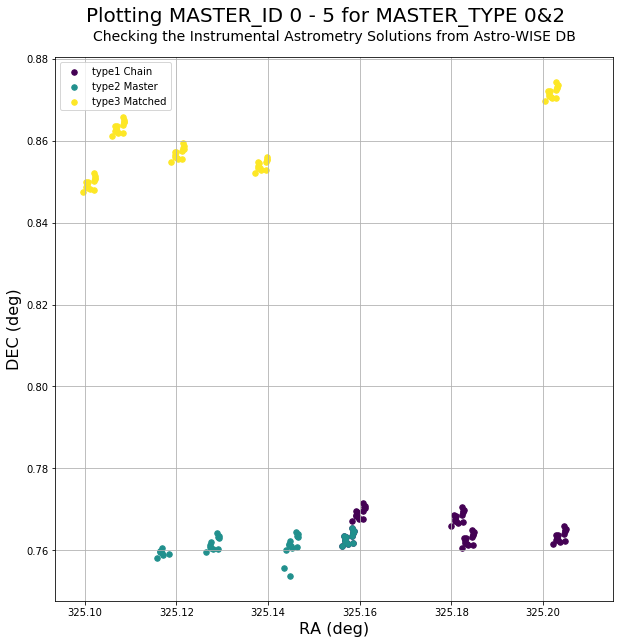

In [25]:
t = ["type1 Chain", "type2 Master", "type3 Matched"]
color = [purple, green_blue, yellow]
mark = ['o', 'x', '4']

for idx_tab, tablename in enumerate(["AssociationTable_1", "AssociationTable_2", "AssociationTable_3"]):
    query_aid = '''SELECT DISTINCT AID_PAIR FROM {}'''.format(tablename)
    out = run_query(query_aid, output='array')
    print("For {} association are {} unique associate identifiers found in table {}".format(t[idx_tab], len(out), tablename))

fig, ax = plt.subplots(figsize=(10,10))
    
for idx_tab, tablename in enumerate(["MasterTable_1", "MasterTable_2", "MasterTable_3"]):
    query_UniqueAID_1 = '''SELECT RA, DEC FROM {} WHERE MASTER_ID IN (0, 1, 2, 3, 4) AND MASTER_TYPE IN (0, 1)'''.format(tablename)
    RA1, DEC1 = run_query(query_UniqueAID_1, output='array')    
    
    ax.scatter(RA1, DEC1, color=color[idx_tab], marker = 'o', s=30, rasterized=True, label = '{}'.format(t[idx_tab])) 

fig.suptitle("Plotting MASTER_ID 0 - 5 for MASTER_TYPE 0&2", fontsize=20, y=.95)
ax.set_title("Checking the Instrumental Astrometry Solutions from Astro-WISE DB", fontsize=14, y=1.02)
ax.xaxis.set_label_text("RA (deg)", fontsize=16)
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:3.2f}"))
ax.yaxis.set_label_text("DEC (deg)", fontsize=16)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:3.2f}"))
ax.legend()

ax.grid(True)
filename = "./plots/TestAIDcounting_associatelisttype.pdf"
fig.savefig(filename, bbox_inches='tight', pad_inches=0)

fig.show()


<center><i><b>Figure 1:</b> This plot reveals that the numbering of associations is completely random when starting to use an other type of associating  </i></center>

fig, ax = plt.subplots(figsize=(10,10))
    
for idx_tab, tablename in enumerate(["MasterTable_1", "MasterTable_2", "MasterTable_3"]):
    query_UniqueAID_1 = '''SELECT RA, DEC FROM {} WHERE MASTER_TYPE IN (0)'''.format(tablename)
    RA1, DEC1 = run_query(query_UniqueAID_1, output='array')    
    
    ax.scatter(RA1, DEC1, color=color[idx_tab], marker = mark[idx_tab], s=30, rasterized=True, label = '{}'.format(t[idx_tab])) 

fig.suptitle("Plotting MASTER_ID's for MASTER_TYPE 0 = 'USNO-B1.0'", fontsize=20, y=.95)
ax.set_title("Checking the External Astrometry Solutions from Astro-WISE DB", fontsize=14, y=1.02)
ax.xaxis.set_label_text("RA (deg)", fontsize=16)
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:3.2f}"))
ax.yaxis.set_label_text("DEC (deg)", fontsize=16)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:3.2f}"))
ax.legend()

ax.grid(True)
filename = "./plots/TestAIDexternal_associatelisttype.pdf"
fig.savefig(filename, bbox_inches='tight', pad_inches=0)

fig.show()


<center><i><b>Figure 2:</b>  This figure clearly reveals that master associaiton takes all USNO-B1.0 sources as reference, but also gives them an AID in the $\texttt{AssociateList}$
 <a id = “f3” LOC></a>

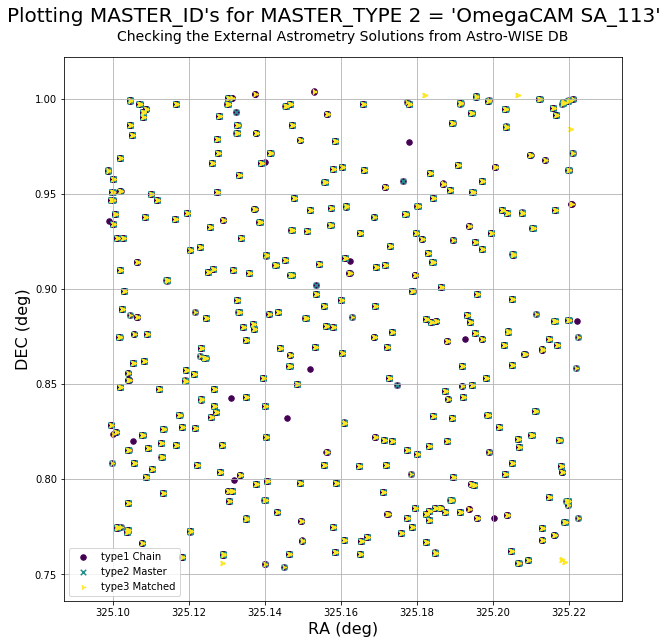

In [20]:
fig, ax = plt.subplots(figsize=(10,10))
    
for idx_tab, tablename in enumerate(["MasterTable_1", "MasterTable_2", "MasterTable_3"]):
    query_UniqueAID_1 = '''SELECT RA, DEC FROM {} WHERE MASTER_TYPE IN (2)'''.format(tablename)
    RA1, DEC1 = run_query(query_UniqueAID_1, output='array')    
    
    ax.scatter(RA1, DEC1, color=color[idx_tab], marker = mark[idx_tab], s=30, rasterized=True, label = '{}'.format(t[idx_tab])) 

fig.suptitle("Plotting MASTER_ID's for MASTER_TYPE 2 = 'OmegaCAM SA_113'", fontsize=20, y=.95)
ax.set_title("Checking the External Astrometry Solutions from Astro-WISE DB", fontsize=14, y=1.02)
ax.xaxis.set_label_text("RA (deg)", fontsize=16)
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:3.2f}"))
ax.yaxis.set_label_text("DEC (deg)", fontsize=16)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:3.2f}"))
ax.legend()

ax.grid(True)
filename = "./plots/TestAIDexternal_associatelisttype.pdf"
fig.savefig(filename, bbox_inches='tight', pad_inches=0)

fig.show()

<center><i><b>Figure 3:</b>  The figure reveals differences between the types of assiciations. We do not completely understand the reasons </i></center> 

    
### Checking the importance of `AssociateList.associatelisttype` on the stored associates in `AssociateList.associates`

<a id = “f4” LOC></a>

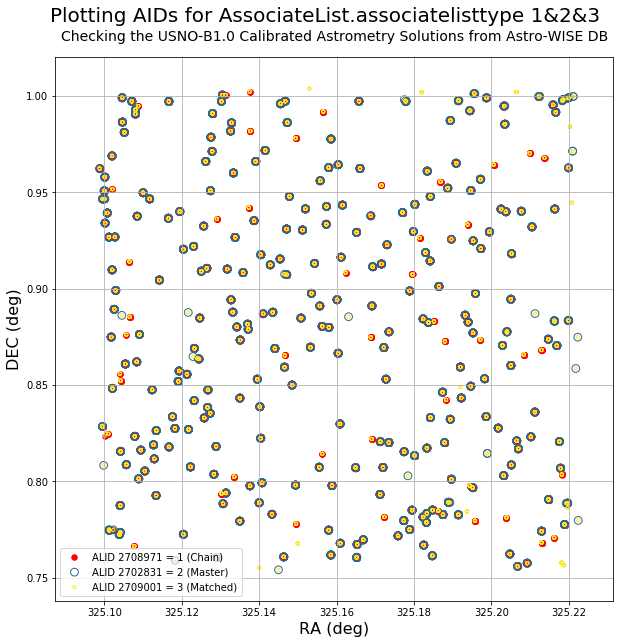

In [23]:
fig, ax = plt.subplots(figsize=(10,10))

query_UniqueAID_1 = '''SELECT RA, DEC FROM MasterTable_1 WHERE MASTER_ID IN (SELECT DISTINCT AID_PAIR FROM AssociationTable_1) AND MASTER_TYPE IS 2'''
RA1, DEC1 = run_query(query_UniqueAID_1, output='array')

query_UniqueAID_2 = '''SELECT RA, DEC FROM MasterTable_2 WHERE MASTER_ID IN (SELECT DISTINCT AID_PAIR FROM AssociationTable_2) AND MASTER_TYPE IS 2'''
RA2, DEC2 = run_query(query_UniqueAID_2, output='array')

query_UniqueAID_3 = '''SELECT RA, DEC FROM MasterTable_3 WHERE MASTER_ID IN (SELECT DISTINCT AID_PAIR FROM AssociationTable_3) AND MASTER_TYPE IS 2'''
RA3, DEC3 = run_query(query_UniqueAID_3, output='array')

ax.scatter(RA1, DEC1, color=cum_red, marker = 'o', s=30, rasterized=True, label = 'ALID 2708971 = 1 (Chain)') 
ax.scatter(RA2, DEC2, color=blue, marker = 'o', s=60, rasterized=True, facecolors='none', edgecolors=blue, label = 'ALID 2702831 = 2 (Master)') 
ax.scatter(RA3, DEC3, color=yellow, marker = 'o', s=10, facecolors='none', edgecolors=yellow, rasterized=True, label = 'ALID 2709001 = 3 (Matched)') 

fig.suptitle("Plotting AIDs for AssociateList.associatelisttype 1&2&3", fontsize=20, y=.95)
ax.set_title("Checking the USNO-B1.0 Calibrated Astrometry Solutions from Astro-WISE DB", fontsize=14, y=1.02)
ax.xaxis.set_label_text("RA (deg)", fontsize=16)
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:3.2f}"))
ax.yaxis.set_label_text("DEC (deg)", fontsize=16)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:3.2f}"))
ax.legend()

ax.grid(True)
filename = "./plots/TestAssociateListType1and2.pdf"
fig.savefig(filename, bbox_inches='tight', pad_inches=0)

fig.show()


<center><i><b>Figure 4:</b> The <font color="#FD0306"> <b>red circles</b>  </font> are obtained by chain association, the <font color="#31688e"> <b>blue circles</b></font>  represent the master association and the <font color="#fde725"> <b>yellow dots </b></font> are obtained by matched association.  </i></center> 

We choose to go on with the Matched association. It seems to be the case that Matched shows the most association. Especially those that do not have a reference object for the USNO-B!.0 reference catalogue are interesting! This is how our system can add new $\texttt{CelestialObject}$s to our own reference system.   

<a id = "green2" testeval></a>

<div class="alert alert-block alert-success">
<b>NOTE:</b> The information will now continue with the information presented in the Master Thesis.
</div>

[ <font color="#35b779"> Jump back to first green block </font>](#green1)

<br><br>
[Go back to list of contents](#LOC)
<a id = "6.4" testeval></a>

***
# Testing and Evaluation
***
    


#### Checking Astrometrical solutions

```
'''SELECT DISTINCT CO_ID FROM AssociationTable'''
'''SELECT RA, DEC FROM MasterTable WHERE MASTER_TYPE IS {}''' 

where {} for [1,2,0] = ['Instrumental', 'Calibrated', 'External']
```

<a id = “figure1” LOC></a>

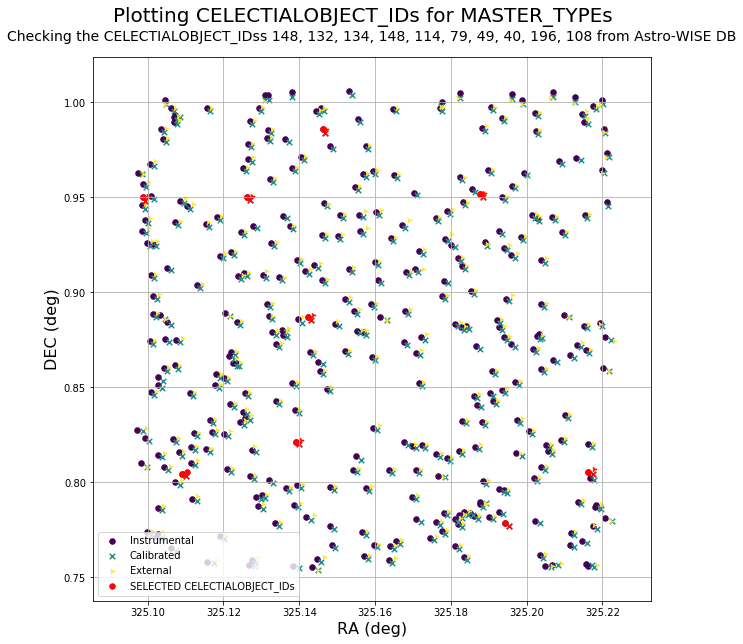

In [16]:
db_Chapter6 = "data/MasterCatalogue_Chapter6.db"

types = [1, 2, 0]
type_names = ['Instrumental', 'Calibrated', 'External']
refcats = ['INSTRUMENT','USNO-B1.0', 'NULL']
color = [purple, green_blue, yellow]
mark = ['o', 'x', '4']

query_aid = '''SELECT DISTINCT CO_ID FROM {}'''.format('AssociationTable')
out = run_query(query_aid, output='array', db_file=db_Chapter6)
# print(str(out).strip("[]"))
idx_red = list(np.random.randint(1,200,10))

fig, ax = plt.subplots(figsize=(10,10))

for idx_t, tp in enumerate(types):
    try:
        query_UniqueAID_1 = '''SELECT RA, DEC FROM MasterTable WHERE MASTER_TYPE IS {} AND CO_ID IN ({}) '''.format(tp, str(list(out)).strip("[]"))
        RA1, DEC1 = run_query(query_UniqueAID_1, output='array', db_file=db_Chapter6)   
        ax.scatter(RA1, DEC1, color=color[idx_t], marker = mark[idx_t], s=30, rasterized=True, label = '{}'.format(type_names[idx_t])) 
    except:
        pass
for idx_t, tp in enumerate(types):
    try:
        query_UniqueAID_1 = '''SELECT RA, DEC FROM MasterTable WHERE MASTER_TYPE IS {} AND CO_ID IN ({})'''.format(tp, str(idx_red).strip("[]"))
        RA1, DEC1 = run_query(query_UniqueAID_1, output='array', db_file=db_Chapter6)   
        ax.scatter(RA1, DEC1, color=cum_red, marker = mark[idx_t], s=30, rasterized=True)#, label = '{}'.format(type_names[idx_t])) 
    except:
        pass

ax.scatter(RA1[0], DEC1[0], color=cum_red, marker = mark[0], s=30, rasterized=True, label = 'SELECTED CELECTIALOBJECT_IDs') 

fig.suptitle("Plotting CELECTIALOBJECT_IDs for MASTER_TYPEs", fontsize=20, y=.95)
ax.set_title("Checking the CELECTIALOBJECT_IDss {} from Astro-WISE DB".format(str(idx_red).strip("[]")), fontsize=14, y=1.02)
ax.xaxis.set_label_text("RA (deg)", fontsize=16)
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:3.2f}"))
ax.yaxis.set_label_text("DEC (deg)", fontsize=16)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:3.2f}"))
ax.legend()

xlim = ax.get_xlim()
ylim = ax.get_ylim()

ax.grid(True)
fig.show()


<center><i><b>Figure 5:</b>  This figure reveals the differences in astrometry for the different types of $\texttt{AstrometricSolution}$s. 
The <font color="#440154"> <b>purple circles</b></font> are the Instrument astrometric solutions, the <font color="#21908d"> <b>green blue crosses</b></font>  are the calibrated USNO-B1.0 solutions and the <font color="#fde725"> <b>yellow crosses </b></font> are the USNO-B1.0 reference positions. 
The 10 clusters  of <font color="#FD0306"> <b>red circles</b>  </font>illustrate that the records that have the same `CO_ID` do represent the same $\texttt{CelestialObject}$. 
  </i></center> 

<br><br>

[Go back to list of contents](#LOC)

<a id = "6.5" LOC></a>
***
# How to use the EMC System?
***


#### Obtaining all records that belong to one $\texttt{CelestialObject}$


<a id = “figure2” LOC></a>

SELECT RA, DEC FROM MasterTable WHERE CO_ID IS 6 AND MASTER_TYPE = 0


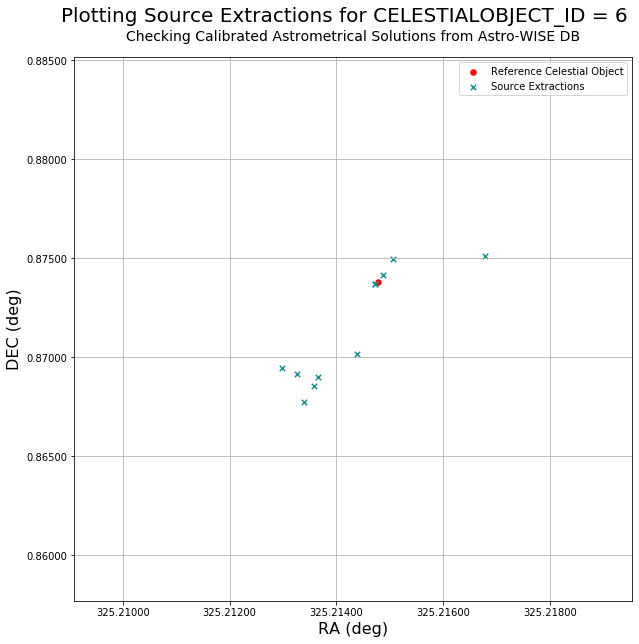

In [25]:
def plot_all_SE(AW_aid, db_file):
    types = [1, 2, 0]
    type_names = ['Instrumental', 'Calibrated', 'External']
    refcats = ['INSTRUMENT','USNO-B1.0', 'NULL']
    color = [purple, green_blue, yellow]
    mark = ['o', 'x', '4']

    fig, ax = plt.subplots(figsize=(10,10))

    slidsid1 = "SELECT DI_ID1, S_ID1 FROM AssociationTable WHERE CO_ID = {}".format(AW_aid)
    slidsid2 = "SELECT DI_ID2, S_ID2 FROM AssociationTable WHERE CO_ID = {}".format(AW_aid)
    ss1 = run_query(slidsid1, output='tuple', db_file=db_file)
    ss2 = run_query(slidsid2, output='tuple', db_file=db_file)
    # Obtain unique combination of (SLID, SID) with Master_ID = AID
    uniq = (list(set(ss1+ss2)))
    # Remove REFCATS from list
    uniq_without_REFCAT = [i for i in uniq if i[0] != 565361]
    # but keep the information stored to ingest directly into the MasterCatalogue
    slid_sid_refcat = set(uniq)-set(uniq_without_REFCAT)
        
    attributes_AS = ['CD1_1', 'CD1_2', 'CD2_1', 'CD2_2', 'CRPIX1', 'CRVAL1', 'CRPIX2', 'CRVAL2'] #instrumental values
    attributes_AS_cal = ['PV1_0', 'PV1_1', 'PV1_2', 'PV1_3', 'PV1_4', 'PV1_5', 'PV1_6', 'PV1_7', 'PV1_8', 'PV1_9', 'PV1_10', 'PV2_0', 'PV2_1', 'PV2_2', 'PV2_3', 'PV2_4', 'PV2_5', 'PV2_6', 'PV2_7', 'PV2_8', 'PV2_9', 'PV2_10']    

    attributes_AS.extend(attributes_AS_cal)
    attr_string_AS = ', '.join( attr for attr in attributes_AS)
    
    select_astromsol = "SELECT {} FROM AstromSolutionTable WHERE REFCAT IS '{}' AND DI_ID IN ({})".format(attr_string_AS, refcats[1], str([slid_sid[0] for slid_sid in uniq_without_REFCAT]).strip("[]"))
    attribute_val_AS = run_query(select_astromsol, output='array', db_file=db_file)
    
    select_xy = "SELECT X, Y FROM SourceExtractionTable WHERE (DI_ID,S_ID) IN (VALUES{})".format(str([slid_sid for slid_sid in uniq_without_REFCAT]).strip("[]"))
    attribute_val_xy = run_query(select_xy, output='array', db_file=db_file)
            
    RA, DEC = [], []
    
    pv_values='present'
    
    for idx_slid_sid, slid_sid in enumerate(attribute_val_AS[0]):
        colomn_values = list([att[idx_slid_sid] for att in attribute_val_AS])
        AP = AstromParameters(colomn_values, attributes_AS, pv_values)
        if pv_values == 'present':
            ra, dec = AP.transform_calib(attribute_val_xy[0][0], attribute_val_xy[1][0])
        elif pv_values == 'ignore':
            ra, dec = AP.transform_instr(attribute_val_xy[0][0], attribute_val_xy[1][0])
        else:
            print("Check your AstrometricSolutions!")
            break
        RA.append(ra); DEC.append(dec)   
    
    if len(slid_sid_refcat) < 1:
        print("No External reference source found for MASTER_ID = {}".format(AW_aid))
        ax.set_xlim(np.mean(RA)-5*np.std(RA), np.mean(RA)+5*np.std(RA))
        ax.set_ylim(np.mean(DEC)-5*np.std(DEC), np.mean(DEC)+5*np.std(DEC))

    else: 
        query_area = '''SELECT RA, DEC FROM MasterTable WHERE CO_ID IS {} AND MASTER_TYPE = 0'''.format(AW_aid)
        print(query_area)
        RA_ref, DEC_ref = run_query(query_area, output='array', db_file=db_file)
        ax.scatter(RA_ref, DEC_ref, color=cum_red, marker = mark[0], s=30, rasterized=True, label = 'Reference Celestial Object')
        ax.set_xlim(np.mean(RA+RA_ref)-5*np.std(RA+RA_ref), np.mean(RA+RA_ref)+5*np.std(RA+RA_ref))
        ax.set_ylim(np.mean(DEC+DEC_ref)-5*np.std(DEC+DEC_ref), np.mean(DEC+DEC_ref)+5*np.std(DEC+DEC_ref))
 
    ax.scatter(RA, DEC, color=color[1], marker = mark[1], s=30, rasterized=True)
    ax.scatter(RA[0], DEC[0], color=color[1], marker = mark[1], s=30, rasterized=True, label = 'Source Extractions') 
 
    fig.suptitle("Plotting Source Extractions for CELESTIALOBJECT_ID = {}".format(AW_aid), fontsize=20, y=.95)
    ax.set_title("Checking Calibrated Astrometrical Solutions from Astro-WISE DB", fontsize=14, y=1.02)
    ax.xaxis.set_label_text("RA (deg)", fontsize=16)
    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:3.5f}"))
    ax.yaxis.set_label_text("DEC (deg)", fontsize=16)
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:3.5f}"))
    ax.legend()

    ax.grid(True)
    filename = "./plots/PlotSourceExtractions_AID{}.pdf".format(AW_aid)
    fig.savefig(filename, bbox_inches='tight', pad_inches=0)

    return fig.show()

db_Chapter6 = db_Master = "data/MasterCatalogue_Chapter6.db"

plot_all_SE(AW_aid=6, db_file=db_Chapter6)

<center><i><b>Figure 6:</b>  Using the unique `CO_ID` we are able to select the $\texttt{SourceExtraction}$s that were matched to a $\texttt{CelestialObject}$ </i></center> 
<a id = “f7” LOC></a>

#### Obtaining all records that belong to one UPDATE in a specific area


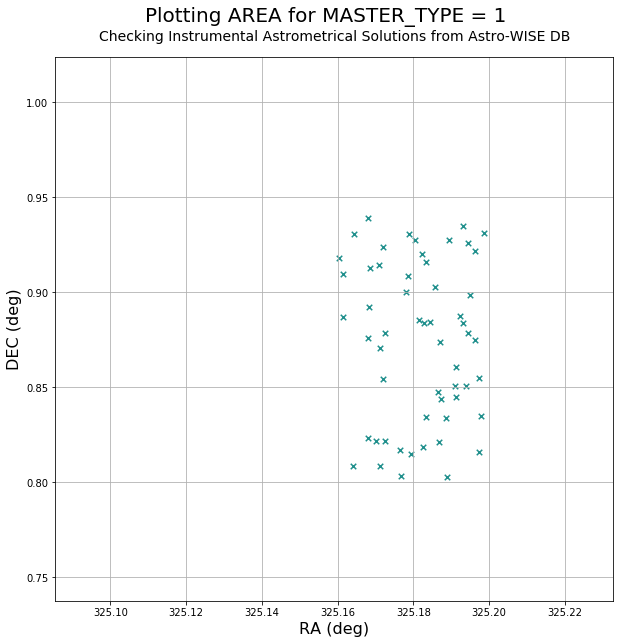

In [26]:
db_MasterCh6 = "../../mastertable/KiDS/MasterCatalogue_Ch6.db"


types = [1, 2, 0]
type_names = ['Instrumental', 'Calibrated', 'External']
refcats = ['INSTRUMENT','USNO-B1.0', 'NULL']
color = [purple, green_blue, yellow]
mark = ['o', 'x', '4']

fig, ax = plt.subplots(figsize=(10,10))

query_area = '''SELECT RA, DEC FROM MasterTable WHERE (RA < 325.20 AND RA >= 325.16) AND (DEC <0.94 AND DEC >= 0.80) AND MASTER_TYPE IS 1 '''
RA1, DEC1 = run_query(query_area, output='array', db_file=db_MasterCh6)  #

ax.scatter(RA1, DEC1, color=color[1], marker = mark[1], s=30, rasterized=True)#, label = '{}'.format(type_names[idx_t])) 

# print(str(out).strip("[]"))
idx_red = list(np.random.randint(1,200,10))

fig.suptitle("Plotting AREA for MASTER_TYPE = 1", fontsize=20, y=.95)
ax.set_title("Checking Instrumental Astrometrical Solutions from Astro-WISE DB".format(str(idx_red).strip("[]")), fontsize=14, y=1.02)
ax.xaxis.set_label_text("RA (deg)", fontsize=16)
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:3.2f}"))
ax.yaxis.set_label_text("DEC (deg)", fontsize=16)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:3.2f}"))
ax.set_xlim(xlim)
ax.set_ylim(ylim)
# ax.legend()

ax.grid(True)
filename = "./plots/Testarea.pdf"
fig.savefig(filename, bbox_inches='tight', pad_inches=0)

fig.show()


<center><i><b>Figure 7:</b>  Using our $\texttt{MasterCatalogue}$ we are able to slect specific areas for a specific update/upgrade. </i></center> 

[Go to list of contents to navigate through notebook](#LOC)